# Hands-on Advanced Deep Learning Time Series Forecasting with Tensors

# Easy Time-Series

In [1]:
#!sudo yum install graphviz -y

In [2]:
#!pip install pydot
#!pip install graphviz

In [3]:
#!pip install keras==2.8.0 tensorflow==2.8.0

In [4]:
#!pip install statsmodels

In [5]:
#!pip install keras-mdn-layer
#!pip install tensorflow_probability

In [6]:
#!pip install keras_multi_head
#!pip install keras-self-attention
#!pip install keras-tcn

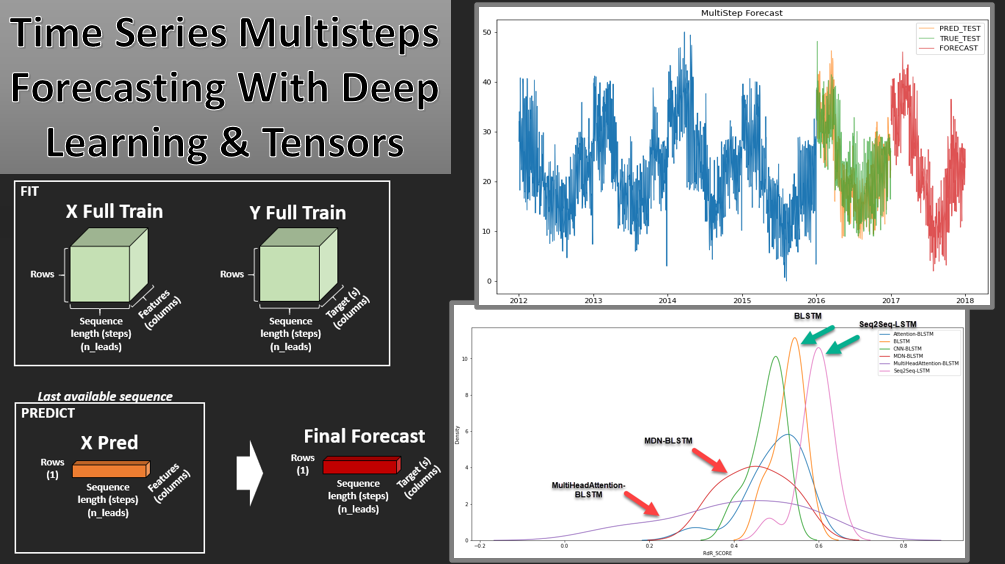

In [7]:
from IPython.display import Image
Image(filename='/opt/continuum/data/image/cover.png')

How can we forecast long-term multi-steps into the futur using deep learning models and tensors ? This article will deep dive this question using 3 different time series and a diversity of neural network architectures.

You will learn how to convert a dataframe time serie to a 3d tensor and then, how to forecasts multiple steps into the future while validating the results.

At the end of this article, there is a link to the notebook used as well as the time series csv files.

Enjoy!

 <a class="anchor" id="menu"></a>
# Table of content:

### [Section#1 - Data](#P1)
[1.1 Loading the Time Series](#section1.1)<br/>
[1.2 Exploring the Time Series](#section1.2)<br/>
        
### [Section#2 - Feature Engineering](#P2)
[2.1 Train-Test Split Scale](#section2.1)<br/>
[2.2 Feature Extraction - Seasonal Means](#section2.2)<br/>
[2.3 Feature Extraction - Lagged Values](#section2.3)<br/>
[2.4 Feature Extraction - Fourier terms](#section2.4)<br/>
[2.5 Final dataset - Merge all features + Differenciation, Seasonality, Trend](#section2.5)<br/>

### [Section#3 - From 2D Matrice to 3D Tensor](#P3)
[3.1 3D Train-Test set](#section3.1)<br/>
[3.2 3D Forecast set](#section3.2)<br/>

### [Section#4 - RdR Score Performance Metric](#P4)

### [Section#5 - BiLSTM](#P5)
[5.1 BiLSTM Architecture](#section5.1)<br/>
[5.2 BiLSTM Training](#section5.2)<br/>
[5.3 BiLSTM Validation](#section5.3)<br/>
[5.4 BiLSTM Forecasting](#section5.4)<br/>

### [Section#6 - Seq2Seq](#P6)
[6.1 Seq2Seq Architecture](#section6.1)<br/>
[6.2 Seq2Seq Training](#section6.2)<br/>
[6.3 Seq2Seq Validation](#section6.3)<br/>
[6.4 Seq2Seq Forecasting](#section6.4)<br/>

### [Section#7 - CNN-BiLSTM](#P7)
[7.1 CNN-BiLSTM Architecture](#section7.1)<br/>
[7.2 CNN-BiLSTM Training](#section7.2)<br/>
[7.3 CNN-BiLSTM Validation](#section7.3)<br/>
[7.4 CNN-BiLSTM Forecasting](#section7.4)<br/>

### [Section#8 - TCN-BiLSTM](#P8)
[8.1 TCN-BiLSTM Architecture](#section8.1)<br/>
[8.2 TCN-BiLSTM Training](#section8.2)<br/>
[8.3 TCN-BiLSTM Validation](#section8.3)<br/>
[8.4 TCN-BiLSTM Forecasting](#section8.4)<br/>

### [Section#9 - MDN-BiLSTM](#P9)
[9.1 MDN-BiLSTM Architecture](#section9.1)<br/>
[9.2 MDN-BiLSTM Training](#section9.2)<br/>
[9.3 MDN-BiLSTM Validation](#section9.3)<br/>
[9.4 MDN-BiLSTM Forecasting](#section9.4)<br/>

### [Section#10 - Attention-BiLSTM](#P10)
[10.1 Attention-BiLSTM Architecture](#section10.1)<br/>
[10.2 Attention-BiLSTM Training](#section10.2)<br/>
[10.3 Attention-BiLSTM Validation](#section10.3)<br/>
[10.4 Attention-BiLSTM Forecasting](#section10.4)<br/>

### [Section#11 - Seq2SeqAttention](#P11)
[11.1 Seq2SeqAttention Architecture](#section11.1)<br/>
[11.2 Seq2SeqAttention Training](#section11.2)<br/>
[11.3 Seq2SeqAttention Validation](#section11.3)<br/>
[11.4 Seq2SeqAttention Forecasting](#section11.4)<br/>

### [Section#12 - MultiHeadAttention-BiLSTM](#P12)
[12.1 MultiHeadAttention-BiLSTM Architecture](#section12.1)<br/>
[12.2 MultiHeadAttention-BiLSTM Training](#section12.2)<br/>
[12.3 MultiHeadAttention-BiLSTM Validation](#section12.3)<br/>
[12.4 MultiHeadAttention-BiLSTM Forecasting](#section12.4)<br/>

### [Section#13 - Time2Vec-BiLSTM](#P13)
[13.1 Time2Vec-BiLSTM Architecture](#section13.1)<br/>
[13.2 Time2Vec-BiLSTM Training](#section13.2)<br/>
[13.3 Time2Vec-BiLSTM Validation](#section13.3)<br/>
[13.4 Time2Vec-BiLSTM Forecasting](#section13.4)<br/>

### [Section#14 - Time2Vec-Transformer](#P14)
[14.1 Time2Vec-Transformer Architecture](#section14.1)<br/>
[14.2 Time2Vec-Transformer Training](#section14.2)<br/>
[14.3 Time2Vec-Transformer Validation](#section14.3)<br/>
[14.4 Time2Vec-Transformer Forecasting](#section14.4)<br/>

### [Section#15 - Average Ensemble Model](#P15)
[15.1 Average Ensemble Model Validation](#section15.1)<br/>
[15.2 Average Ensemble Model Forecasting](#section15.2)<br/>

### [Section#16 - Final Benchmark](#P16)

In [8]:
with open('seed_increment.txt') as f:
    lines = f.readlines()

increment = int(lines[0])
new_increment = int(lines[0]) + 1

with open('seed_increment.txt', 'w') as f:
    f.write(str(new_increment))
    
print(increment)

22


In [9]:
import os
#***********FIX the random seed for reproductible results. Different seed, different results!
seed_value = new_increment #10--> TCN wow
os.environ["PYTHONHASHSEED"] = str(seed_value)

import numpy as np
import tensorflow as tf
import random as python_random

def reset_seeds(seed_value):
   np.random.seed(seed_value) 
   python_random.seed(seed_value)
   tf.random.set_seed(seed_value)
   tf.keras.utils.set_random_seed(seed_value)

reset_seeds(seed_value) 


import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin

import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.relativedelta import relativedelta

from pandas.tseries.offsets import MonthEnd
from datetime import datetime, date
from datetime import date, timedelta
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, BatchNormalization, RepeatVector, TimeDistributed, Activation, Input, Lambda, Bidirectional, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout, dot, multiply, concatenate, Layer
from keras.callbacks import EarlyStopping, Callback
from keras.utils.vis_utils import plot_model, model_to_dot
import keras.backend as K

import keras
from keras import layers

from mdn import MDN, get_mixture_loss_func, sample_from_output
from keras_multi_head import MultiHead, MultiHeadAttention
from keras_self_attention import SeqSelfAttention
from tcn import TCN

from ts_transform import TransformerDiff, TransformerLog
from rdr_scorer import RdR_scorer

from ThymeBoost import ThymeBoost as tb
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

/opt/continuum/.conda/envs/nb_base2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/opt/continuum/.conda/envs/nb_base2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


<a class="anchor" id="P1"></a>
# Section#1 - Data

<a class="anchor" id="section1.1"></a>
### 1.1 - Loading the Time Series

Feel free to change it for your own time serie data and it should work! (just be sure that the dates and column type are correct)

In [10]:
ts_sequence = pd.read_csv('/opt/continuum/data/raw/easy_ts.csv', sep = ';') ### Change for your own dataset
ts_sequence['DATE'] = pd.to_datetime(ts_sequence['DATE'])

print('ts_sequence', ts_sequence.shape)
ts_original = ts_sequence.copy()

ts_sequence (223, 3)


Defining the parameters of each time series

In [11]:
### Change parameters if needed!
dict_ts_sequence = {'dataset': ts_sequence, 
                    'dataset_orig' : ts_sequence, 
                    'ts_original' : ts_original.copy(),
                    'stabilize_variance' : False, 
                    'stabilize_mean' : False, 
                    'seasonal_features' : True,
                    'diff_trend' : False,
                    'exog' : False,
                    'fourier_terms' : False,
                    
                    'date_colname': 'DATE', #The date column name in dataframe
                    'y_colname' : 'EASY', #The time serie of interest (column name)
                    'n_leads' : 24, #We will forecast 24 periods in the futur
                    'n_lags': 16, #We will keep 16 periods in the past as features
                    'freq': 12} #number of periods in a year (frequency): 4=quarterly, 12=monthly, 52=weekly, 365=daily


<a class="anchor" id="section1.2"></a>
### 1.1 - Exploring the Time Series

*WARNING: Here, we will only take a quick visual look at the time series as the goal is not to deep dive into time series analysis (can be a whole article just on this step!!!)

In [12]:
def exploring_time_serie(data, 
                         date_colname,
                         y_colname, 
                         exogenous = False):
    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(data[date_colname], data[y_colname])
    plt.title('Time Serie of interest')
    plt.show()
    if exogenous == True:
        fig, ax = plt.subplots(figsize = (18, 9))
        print('Exogenous features - Multivariate')
        plt.title('Exogenous TIme Series (Multivariate)')
        for col in data.columns.difference([date_colname, 
                                            'Date', 'date']):
            print(col)
            if col == y_colname:
                ax.plot(data[date_colname], 
                    np.log1p(data[col]),
                       linewidth = 3)
            else:
                ax.plot(data[date_colname], 
                    np.log1p(data[col]),
                        linewidth = 1,
                       alpha = 0.6)

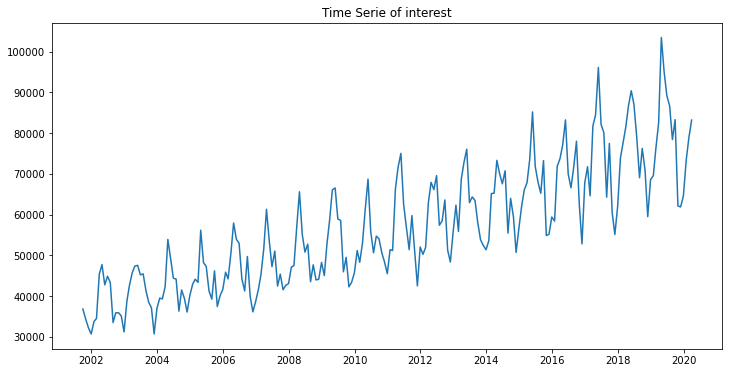

In [13]:
exploring_time_serie(dict_ts_sequence['dataset'], 
                     dict_ts_sequence['date_colname'], 
                     dict_ts_sequence['y_colname'])

This is a monthly time series. We will test and forecast 24 months into the futur.
We can observe that the time series is deterministic. There seems to have a strong positive trend and a strong monthly seasonality.

We will check rapidly with a decomposition to confirm what we observed above:

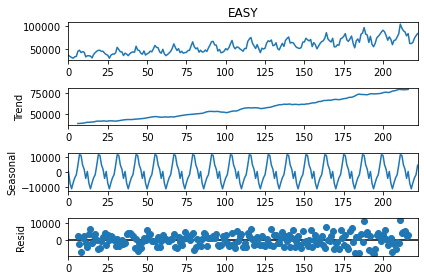

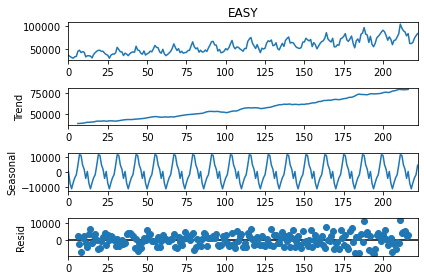

In [14]:
result = seasonal_decompose(ts_sequence[dict_ts_sequence['y_colname']], model='additive', period = dict_ts_sequence['freq'])
result.plot()

<a class="anchor" id="P1"></a>
# Section#2 - Feature Engineering

<a class="anchor" id="section2.1"></a>
### 2.1 - Train-Test Split Scale

We will start by splitting our dataset in Train and Test sets to be sure we do not include any overfitting features in our test set along the way. (Common mistake have seen soooo many times!). For example, we will calculate seasonal means. we HAVE TO get rid of the test set values BEFORE calculating the means or we will overfitting using test data in our train data.

In [15]:
def split_ts_train_test(ts,
                        date_colname,
                        y_colname_list,
                        n_leads):
    
    ts_train = ts.iloc[:-n_leads, :]
    ts_test = ts.iloc[-n_leads:, :]
       
    return ts, ts_train, ts_test

<a class="anchor" id="section2.2"></a>
### 2.2 - Feature Extraction - Seasonal Means

Now, we can calculate our seasonal means features only on the train set (as we are not supposed to know the test set in the feature !). 

In [16]:
def seasonal_means_extract(dataset, date_colname, y_colname, n_leads, freq, y_scaler_sequence = None):
    """Calculate the seasonal means of a given time serie

    Args:
        dataset (dataframe): pandas dataframe
        date_colname (str): Name of the date column in the given dataframe
        y_colname (str): Name of the time serie column in the given dataframe
        n_leads (int): number of period to forecast into the futur
        freq (int): frequency, periods of the time series (1=yearly, 12=monthly, 52=weekly, 365=daily)

    Returns:
        list: a list of strings representing the header columns
    """
    keep_cols = list(dataset.columns)
    
    timeserie = dataset[[date_colname, y_colname]].copy()
    if y_scaler_sequence != None:
        timeserie[y_colname] = y_scaler_sequence.inverse_transform(timeserie[[y_colname]]).ravel()
    
    timeserie.index.name = 'index'
    timeserie.index = pd.to_datetime(timeserie[date_colname])
    timeserie.index.name = 'index'
    
    min_year = np.min(timeserie.index.year)
    max_year = np.max(timeserie.index.year) + int(n_leads/freq) + 5

    all_dates = pd.DataFrame(pd.date_range(pd.to_datetime(str(min_year) + '-01-01'),
                  pd.to_datetime(str(max_year) + '-12-31')-timedelta(days=1),freq='d'), columns = ['ds'])

    if freq == 12:

        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter

        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']

        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
    elif freq == 4:    
        timeserie['QUARTER'] = timeserie.index.quarter.astype(str)
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['QUARTER_YEAR'] = timeserie['YEAR'] + '_' + timeserie['QUARTER']

        all_dates['QUARTER'] = all_dates['ds'].dt.quarter.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['QUARTER_YEAR'] = all_dates['YEAR'] + '_' + all_dates['QUARTER']
        all_dates = all_dates.groupby(['QUARTER_YEAR']).size().reset_index()
        all_dates.columns = ['QUARTER_YEAR', 'N_DAYS']
        

        timeserie1 = pd.merge(timeserie, quarter_mean, how = 'left', 
                              left_on = 'QUARTER', right_on = 'QUARTER')
        timeserie1.index = timeserie.index


    elif freq == 52:   
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['MONTH'] = timeserie.index.month
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie['YEAR'] = timeserie.index.year.astype(str)
        timeserie['WEEK_YEAR'] = timeserie['YEAR'].astype(str) + '_' + timeserie['WEEK'].astype(str)
        #del timeserie['YEAR']

        all_dates['WEEK'] = all_dates['ds'].dt.week.astype(str)
        all_dates['YEAR'] = all_dates['ds'].dt.year.astype(str)
        all_dates['WEEK_YEAR'] = all_dates['YEAR'] + '_' + all_dates['WEEK']
        all_dates = all_dates.groupby(['WEEK_YEAR']).size().reset_index()
        all_dates.columns = ['WEEK_YEAR', 'N_DAYS']

        #del timeserie['WEEK_YEAR']


        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
    
    elif freq >= 100 and freq <= 600:    
        timeserie['DAY_OF_MONTH'] = timeserie.index.day
        timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
        timeserie['WEEK'] = timeserie.index.week
        timeserie['QUARTER'] = timeserie.index.quarter
        timeserie['MONTH'] = timeserie.index.month
        timeserie['MONTH_WEEK'] = timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
        
        timeserie = timeserie.fillna(0)
     
        day_mean = timeserie[['DAY_OF_MONTH', y_colname]].groupby(['DAY_OF_MONTH']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_MONTH', 'DAY_OF_MONTH_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_MONTH', right_on = 'DAY_OF_MONTH')
        #del timeserie['DAY_OF_MONTH']
        
        day_mean = timeserie[['DAY_OF_WEEK', y_colname]].groupby(['DAY_OF_WEEK']).mean([y_colname]).reset_index()
        day_mean.columns = ['DAY_OF_WEEK', 'DAY_OF_WEEK_MEAN']
        timeserie = pd.merge(timeserie, day_mean, how = 'left', left_on = 'DAY_OF_WEEK', right_on = 'DAY_OF_WEEK')
        #del timeserie['DAY_OF_WEEK']
        
        quarter_mean = timeserie[['QUARTER', y_colname]].groupby(['QUARTER']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['QUARTER', 'QUARTER_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'QUARTER', right_on = 'QUARTER')
        #del timeserie['QUARTER']
        
        quarter_mean = timeserie[['WEEK', y_colname]].groupby(['WEEK']).mean([y_colname]).reset_index()
        quarter_mean.columns = ['WEEK', 'WEEK_MEAN']
        timeserie = pd.merge(timeserie, quarter_mean, how = 'left', left_on = 'WEEK', right_on = 'WEEK')
        #del timeserie['WEEK']
        
        months_mean = timeserie[['MONTH', y_colname]].groupby(['MONTH']).mean([y_colname]).reset_index()
        months_mean.columns = ['MONTH', 'MONTH_MEAN']
        timeserie = pd.merge(timeserie, months_mean, how = 'left', left_on = 'MONTH', right_on = 'MONTH')
        #del timeserie['MONTH']
        
        model_mean = timeserie[['WEEKLY_MONTHLY', y_colname]].groupby(['WEEKLY_MONTHLY']).mean([y_colname]).reset_index()
        model_mean.columns = ['WEEKLY_MONTHLY', 'WEEKLY_MONTHLY_MEAN']
        timeserie = pd.merge(timeserie, model_mean, how = 'left', left_on = 'WEEKLY_MONTHLY', right_on = 'WEEKLY_MONTHLY')
        #del timeserie2['MEAN_MODEL']
    
    timeserie.index = pd.to_datetime(dataset[date_colname])
    
    if y_scaler_sequence != None:
        for col in [col for col in timeserie.columns if '_MEAN' in col]:
            timeserie[col] = y_scaler_sequence.transform(timeserie[[col]]).ravel()
    
    add_cols = list(set(keep_cols) - set(timeserie.columns))
    
    for col in add_cols:
        
        timeserie[col] = dataset[col]

    return timeserie

SEASONALITIES


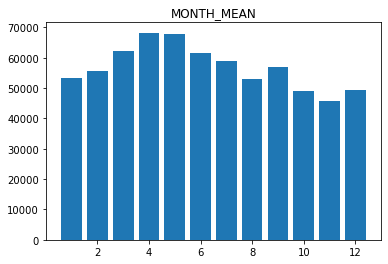

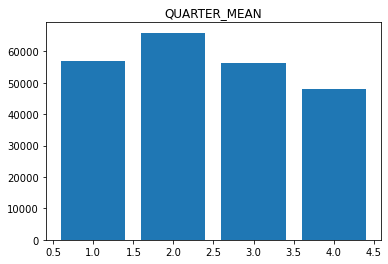

In [17]:
#for key, value in dict_ts.items():
mean_df = seasonal_means_extract(dataset = dict_ts_sequence['dataset'], 
                                 date_colname = dict_ts_sequence['date_colname'], 
                                 y_colname= dict_ts_sequence['y_colname'], 
                                 n_leads= dict_ts_sequence['n_leads'], 
                                 freq= dict_ts_sequence['freq'])
if dict_ts_sequence['freq'] == 12:
    print('SEASONALITIES')
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
else:
    print('SEASONALITIES')
    
    mean_df_distinct = mean_df[['DAY_OF_WEEK','DAY_OF_WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['DAY_OF_WEEK'], mean_df_distinct['DAY_OF_WEEK_MEAN'])
    plt.title('DAY_OF_WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEK','WEEK_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEK'], mean_df_distinct['WEEK_MEAN'])
    plt.title('WEEK_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['MONTH','MONTH_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['MONTH'], mean_df_distinct['MONTH_MEAN'])
    plt.title('MONTH_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['QUARTER','QUARTER_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['QUARTER'], mean_df_distinct['QUARTER_MEAN'])
    plt.title('QUARTER_MEAN')
    plt.show()
    
    mean_df_distinct = mean_df[['WEEKLY_MONTHLY','WEEKLY_MONTHLY_MEAN']].drop_duplicates()
    plt.bar(mean_df_distinct['WEEKLY_MONTHLY'], mean_df_distinct['WEEKLY_MONTHLY_MEAN'])
    plt.title('WEEKLY_MONTH_MEAN')
    plt.show()
    

In [18]:
### This function will be usefull to merge the seasonal means ont he final dataset
def merge_seasonal_features(dataset, seasonal_features):
    timeserie = dataset.copy()
    
    timeserie.index = pd.to_datetime(timeserie.index)

    timeserie.index.name = 'index'
    
    
    
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['DAY_OF_MONTH'] = timeserie.index.day
    timeserie['DAY_OF_WEEK'] = timeserie.index.dayofweek
    timeserie['WEEK'] = timeserie.index.week
    timeserie['MONTH'] = timeserie.index.month
    timeserie['QUARTER'] = timeserie.index.quarter
    timeserie['WEEKLY_MONTHLY'] = timeserie['DAY_OF_WEEK'].astype(str) + timeserie['WEEK'].astype(str) + timeserie['MONTH'].astype(str)
    
    for feat in ['WEEK',
                 'MONTH',
                'QUARTER',
                'DAY_OF_MONTH',
                'DAY_OF_WEEK',
                'WEEKLY_MONTHLY']:
        if feat in seasonal_features.columns:
            seasonal_features_feat = seasonal_features[[feat, feat+'_MEAN']].drop_duplicates().reset_index(drop = True)
            timeserie = pd.merge(timeserie, seasonal_features_feat[[feat, feat+'_MEAN']], how = 'left', left_on = feat, right_on = feat)

            del timeserie[feat]
        else:
            try:
                del timeserie[feat]
            except:
                pass
            pass
    
    for col in timeserie.columns:
        dataset[col] = timeserie[col].values
    
    
    return dataset

<a class="anchor" id="section2.3"></a>
### 2.3 - Feature Extraction - Lagged values

We will then convert our 1D time series into a 2D matrice with X features and y targets. The features will represent actual and lagged values while the targets will represent leaded values. This way, our model will be learning to extrapolate n_leads periods into the futur based on some features (multi-target regression problem).

In [19]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True, feat_str_at_end=True, feat_lag_str = 'TM', feat_lead_str = 'TP'):
    
    if feat_str_at_end == True:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          if i < 10:
              name_i = '0' + str(i)
          else:
              name_i = str(i)
              
          names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'') +'_' + feat_lag_str + name_i) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    else:
        n_vars = 1 if type(data) is list else data.shape[1]
        df = pd.DataFrame(data)
        cols, names = list(), list()
        # input sequence (t-n, ... t-1)
        for i in range(n_in, 0, -1):
          cols.append(df.shift(i))
          names += [(feat_lag_str + '%d' % (i) + str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
        for i in range(0, n_out):
          cols.append(df.shift(-i))
          if i == 0:
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')) for j in range(n_vars)]
          else:
            if i < 10:
                name_i = '0' + str(i)
            else:
                name_i = str(i)
            names += [(str(pd.DataFrame(df.iloc[:, j]).columns.values).replace("']",'').replace("['",'')+'_' + feat_lead_str + name_i) for j in range(n_vars)]
        # put it all together
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        # drop rows with NaN values
        if dropnan:
          agg.dropna(inplace=True)
    return agg

For the sequence time series, we will add 12 lagged value as features (1 year in the past).

Here,"TM" mean "Time Minus", soo it's a lagged n periods feature values of our time series.
Here,"TP" mean "Time Plus", soo it's a leaded n periods target values of our time series (the value we want to forecast into the future).
we juste created a multi-target regression dataframe.

We have to concatenate our seasonal features with our new matrice.

<a class="anchor" id="section2.4"></a>
### 2.4 - Feature Extraction - Fourier terms

In [20]:
def extract_fourier_terms(dataset):
    
    #ts_copy = dataset[[date_colname]]
    dataset['sin365_2'] = np.sin(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['sin365_2'] = StandardScaler().fit_transform(dataset['sin365_2'].values.reshape(-1,1))
    
    dataset['sin365_4'] = np.sin(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['sin365_4'] = StandardScaler().fit_transform(dataset['sin365_4'].values.reshape(-1,1))
    
    dataset['cos365_2'] = np.cos(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['cos365_2'] = StandardScaler().fit_transform(dataset['cos365_2'].values.reshape(-1,1))
    
    dataset['cos365_4'] = np.cos(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['cos365_4'] = StandardScaler().fit_transform(dataset['cos365_4'].values.reshape(-1,1))
    
    dataset['tanh365_2'] = np.tanh(2 * np.pi * dataset.index.dayofyear / 365.25)
    dataset['tanh365_2'] = StandardScaler().fit_transform(dataset['tanh365_2'].values.reshape(-1,1))
    
    dataset['tanh365_4'] = np.tanh(2 * np.pi * 2 * dataset.index.dayofyear / 365.25)
    dataset['tanh365_4'] = StandardScaler().fit_transform(dataset['tanh365_4'].values.reshape(-1,1))
    
    return dataset

<a class="anchor" id="section2.5"></a>
### 2.5 - Final dataset - Merge all features + Differenciation, Seasonality, Trend

In [21]:
def dataprep_pipeline(ts_data, 
                      dict_ts_sequence, 
                      seasonal_features = True,
                      diff_trend = True,
                      exog = True,
                      fourier_terms = True):
    ####SCALING
    y_scaler_forecast = StandardScaler()
    ts_sequence_forecast = ts_data.copy()
    ts_sequence_forecast

    y_data = ts_sequence_forecast[[dict_ts_sequence['y_colname']]].copy()

    y_data = pd.DataFrame(y_scaler_forecast.fit_transform(y_data))
    y_data.columns = [dict_ts_sequence['y_colname']]
    for y_colname in y_data.columns:
        ts_sequence_forecast[y_colname] = y_data[y_colname].values

    y_colname = dict_ts_sequence['y_colname']
    ###CALCULATE SEASONAL MEANS
    if seasonal_features == True:
        seasonal_list = []
        all_cols = [dict_ts_sequence['date_colname'], dict_ts_sequence['y_colname']]

        ts_sequence_seasonal_feats_full = seasonal_means_extract(dataset = ts_data[all_cols], 
                                                         date_colname = dict_ts_sequence['date_colname'], 
                                                         y_colname= y_colname, 
                                                         n_leads= dict_ts_sequence['n_leads'], 
                                                         freq= dict_ts_sequence['freq'],
                                                          y_scaler_sequence = y_scaler_forecast)
        
        ts_sequence_seasonal_feats_full.index = pd.to_datetime(ts_data[dict_ts_sequence['date_colname']])
        del ts_sequence_seasonal_feats_full[dict_ts_sequence['date_colname']]
        del ts_sequence_seasonal_feats_full[y_colname]

    ts_sequence_forecast.index = pd.to_datetime(ts_sequence_forecast['DATE'])
    

    ts_sequence_supervised_full = series_to_supervised(ts_sequence_forecast[[y_colname]], 
                                              n_in=dict_ts_sequence['n_lags'], 
                                              n_out=1, 
                                              dropnan=True, 
                                              feat_str_at_end=True, 
                                              feat_lag_str = 'TM', 
                                              feat_lead_str = 'TP')
    
    ### MERGE SEASONAL MEANS
    if seasonal_features == True:
        ts_sequence_supervised_full = merge_seasonal_features(dataset = ts_sequence_supervised_full.copy(), 
                                                              seasonal_features = ts_sequence_seasonal_feats_full.copy())
        
        for col in ts_sequence_seasonal_feats_full.columns:
            if col in ts_sequence_supervised_full.columns:
                ts_sequence_supervised_full[col] = StandardScaler().fit_transform(ts_sequence_supervised_full[[col]]).ravel()

    ### DIFF TREND
    if diff_trend == True:

        ts_sequence_supervised_full['DIFF_' + y_colname] = StandardScaler().fit_transform(ts_sequence_supervised_full[y_colname].diff().fillna(0).values.reshape(-1,1))

        decomp = seasonal_decompose(ts_sequence_supervised_full[y_colname], model='additive', period = dict_ts_sequence['freq'], extrapolate_trend=1)
        ts_sequence_supervised_full['TREND_' + y_colname] = StandardScaler().fit_transform(decomp.trend.values.reshape(-1,1))
        #ts_sequence_supervised['SEASON'] = StandardScaler().fit_transform(decomp.seasonal.values.reshape(-1,1))

    ### EXOG
    if exog == True:
        exog_cols = []
        all_cols = [dict_ts_sequence['y_colname'], dict_ts_sequence['date_colname'], 'Date','date']
        for col in ts_sequence.columns.difference(all_cols):
            exog_cols.append(col)

        dict_ts_sequence_exog = ts_sequence[exog_cols]

        exog_scaler = StandardScaler()
        dict_ts_sequence_exog = pd.DataFrame(exog_scaler.fit_transform(dict_ts_sequence_exog),
                                             index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']]),
                                             columns = exog_cols)
        


        for col in dict_ts_sequence_exog.columns:
            ts_sequence_supervised_full = pd.merge(ts_sequence_supervised_full, 
                                                   dict_ts_sequence_exog[[col]],
                                                  how = 'left',
                                                  left_index = True,
                                                  right_index = True)
    
    return ts_sequence_supervised_full, y_scaler_forecast

In [22]:
ts_full, ts_sequence_train, ts_sequence_test = split_ts_train_test(ts = dict_ts_sequence['dataset_orig'].copy(),
                                                  date_colname = dict_ts_sequence['date_colname'],
                                                  y_colname_list = dict_ts_sequence['y_colname'],
                                                  n_leads = dict_ts_sequence['n_leads'])


diff_transformer_dict_train = {}
diff_transformer_dict_full = {}

log_transformer_dict_train = {}
log_transformer_dict_full = {}

y_colname =  dict_ts_sequence['y_colname']
log_transformer_full = TransformerLog()
diff_transformer_full = TransformerDiff()

if dict_ts_sequence['stabilize_variance'] == True:
    ts_full[y_colname] = log_transformer_full.fit_transform(ts_full[[y_colname]].values)
    log_transformer_dict_full[y_colname] = log_transformer_full
if dict_ts_sequence['stabilize_mean'] == True:
    ts_full[y_colname] = diff_transformer_full.fit_transform(ts_full[[y_colname]].values)
    diff_transformer_dict_full[y_colname] = diff_transformer_full
    
ts_full = ts_full.dropna()

log_transformer = TransformerLog()
diff_transformer = TransformerDiff()
if dict_ts_sequence['stabilize_variance'] == True:
    ts_sequence_train[y_colname] = log_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    log_transformer_dict_train[y_colname] = log_transformer
if dict_ts_sequence['stabilize_mean'] == True:
    ts_sequence_train[y_colname] = diff_transformer.fit_transform(ts_sequence_train[[y_colname]].values)
    diff_transformer_dict_train[y_colname] = diff_transformer
        
ts_sequence_train = ts_sequence_train.dropna()


dict_ts_sequence['diff_transformer_dict_full'] = diff_transformer_dict_full
dict_ts_sequence['log_transformer_dict_full'] = log_transformer_dict_full
ts_sequence_supervised_full, y_scaler_forecast = dataprep_pipeline(ts_full.copy(), 
                                                                  dict_ts_sequence, 
                                                                  seasonal_features = dict_ts_sequence['seasonal_features'],
                                                                  diff_trend = dict_ts_sequence['diff_trend'],
                                                                  exog = dict_ts_sequence['exog'],
                                                                  fourier_terms = dict_ts_sequence['fourier_terms'])

dict_ts_sequence['diff_transformer_dict_train'] = diff_transformer_dict_train
dict_ts_sequence['log_transformer_dict_train'] = log_transformer_dict_train
ts_sequence_supervised, y_scaler_sequence = dataprep_pipeline(ts_sequence_train.copy(), 
                                                              dict_ts_sequence, 
                                                              seasonal_features = dict_ts_sequence['seasonal_features'],
                                                              diff_trend = dict_ts_sequence['diff_trend'],
                                                              exog = dict_ts_sequence['exog'],
                                                              fourier_terms = dict_ts_sequence['fourier_terms'])

In [23]:
ts_sequence_supervised.columns

Index(['EASY_TM16', 'EASY_TM15', 'EASY_TM14', 'EASY_TM13', 'EASY_TM12',
       'EASY_TM11', 'EASY_TM10', 'EASY_TM09', 'EASY_TM08', 'EASY_TM07',
       'EASY_TM06', 'EASY_TM05', 'EASY_TM04', 'EASY_TM03', 'EASY_TM02',
       'EASY_TM01', 'EASY', 'MONTH_MEAN', 'QUARTER_MEAN'],
      dtype='object')

In [24]:
ts_sequence_supervised.head(1).T

DATE          2003-01-31
EASY_TM16      -1.326273
EASY_TM15      -1.513817
EASY_TM14      -1.675855
EASY_TM13      -1.794749
EASY_TM12      -1.561171
EASY_TM11      -1.502261
EASY_TM10      -0.669839
EASY_TM09      -0.490234
EASY_TM08      -0.870604
EASY_TM07      -0.707810
EASY_TM06      -0.825279
EASY_TM05      -1.579707
EASY_TM04      -1.396864
EASY_TM03      -1.395668
EASY_TM02      -1.454655
EASY_TM01      -1.754983
EASY           -1.183456
MONTH_MEAN     -0.477506
QUARTER_MEAN    0.070423

<a class="anchor" id="P3"></a>
# Section#3 - From 2D Matrice to 3D Tensor

Now, if we want to convert this matrice in a 3d vector:

In [25]:
def prep_data_3d_arch1(data, y_colname_list, date_colname, n_leads):

    #timeserie = data.copy()
    n_step = n_leads
    

    timeserie = data.copy()
    timeserie = timeserie[timeserie.columns.difference([date_colname])]

    Xtimeserie = timeserie[timeserie.columns.difference([date_colname])]

    ytimeserie = timeserie[y_colname_list]
        
    feats = list(Xtimeserie.columns)
    Xlist = []
    ylist = []

    i = 0
    for i in range(0, len(timeserie) - ((n_step*2)-1)):
        #print(i)
        Xlist.append([Xtimeserie.iloc[i: i+n_step].values])
        ylist.append([ytimeserie.iloc[i+n_step: i+(n_step*2)][y_colname_list].values])
    
    Xlist_T = np.array(Xlist).reshape(len(Xtimeserie) - ((n_step*2)-1), n_step, len(Xtimeserie.columns))
    ylist_T = np.array(ylist).reshape(len(ytimeserie) - ((n_step*2)-1), n_step, len(y_colname_list))


    XlistTest = []
    i = 0
    for i in range(len(Xtimeserie) - n_step, len(Xtimeserie)- (n_step-1)):
        XlistTest.append([Xtimeserie.iloc[i: i+n_step].values])
    XlistTest_T = np.array(XlistTest).reshape(1, n_step, len(Xtimeserie.columns))

    Xlist_T_all = Xlist_T.copy()
    ylist_T_all = ylist_T.copy()
    XlistTest_T_all = XlistTest_T.copy()

    return Xlist_T_all, ylist_T_all, XlistTest_T_all, feats

In [26]:
X_train_sequence, y_train_sequence, X_test_sequence, feats = prep_data_3d_arch1(data = ts_sequence_supervised.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])
print(X_train_sequence.shape, y_train_sequence.shape)

(136, 24, 19) (136, 24, 1)


<a class="anchor" id="section3.1"></a>
### 3.1 - 3D Train-Test set

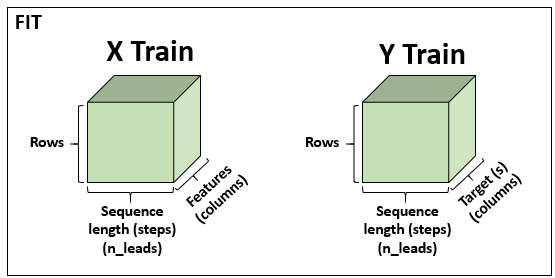

In [27]:
Image(filename='/opt/continuum/data/image/3DTensor-Fit.png')

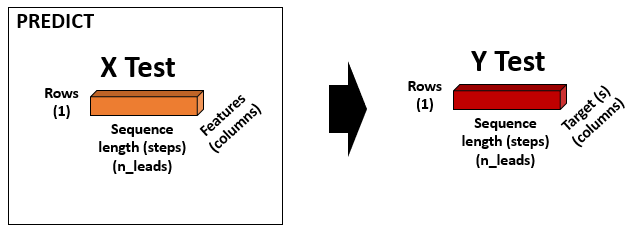

In [28]:
Image(filename='/opt/continuum/data/image/3DTensor-Predict.png')

In [29]:
X_train_sequence, y_train_sequence, X_test_sequence, feats = prep_data_3d_arch1(data = ts_sequence_supervised.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

print(X_train_sequence.shape, y_train_sequence.shape)

#y_test is just the last Y sequence of n_leads form the original time serie

(136, 24, 19) (136, 24, 1)


In [30]:
print(X_train_sequence.shape, y_train_sequence.shape)

dict_explain_tensor = {}
ijk = 0 
for val in X_train_sequence.shape:
    if ijk == 0:
        dict_explain_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_tensor[val])
    ijk = ijk + 1

(136, 24, 19) (136, 24, 1)
136 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
19 Number of columns (Features)


In [31]:
print(X_test_sequence.shape)

(1, 24, 19)


<a class="anchor" id="section3.2"></a>
### 3.2 - 3D Forecast set

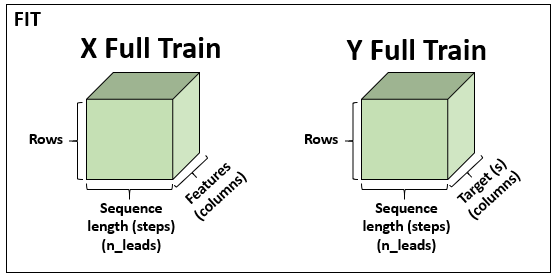

In [32]:
Image(filename='/opt/continuum/data/image/3DTensor-FullFit.png')

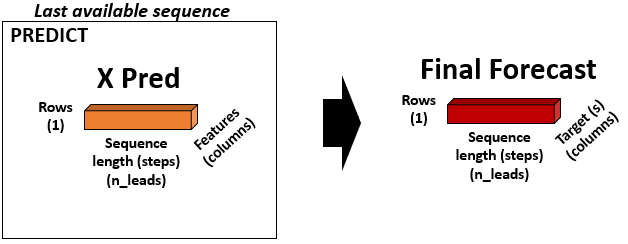

In [33]:
Image(filename='/opt/continuum/data/image/3DTensor-Forecast.png')

In [34]:
X_train_full, y_train_full, X_forecast, feats = prep_data_3d_arch1(data = ts_sequence_supervised_full.copy(),
                                                                    y_colname_list = [dict_ts_sequence['y_colname']],
                                                                    date_colname = dict_ts_sequence['date_colname'],
                                                                    n_leads = dict_ts_sequence['n_leads'])

In [35]:
print(X_train_full.shape, y_train_full.shape)
dict_explain_full_tensor = {}
ijk = 0 
for val in X_train_full.shape:
    if ijk == 0:
        dict_explain_full_tensor[val] = 'Number of rows (Time occurences)'
    elif ijk == 1:
        dict_explain_full_tensor[val] = 'Sequence length - Number of steps to forecasts (n_leads)'
    elif ijk == 2:
        dict_explain_full_tensor[val] = 'Number of columns (Features)'
    print(val, dict_explain_full_tensor[val])
    ijk = ijk + 1

(160, 24, 19) (160, 24, 1)
160 Number of rows (Time occurences)
24 Sequence length - Number of steps to forecasts (n_leads)
19 Number of columns (Features)


<a class="anchor" id="P4"></a>
# Section#4 - RdR Score Performance Metric

The proposed RdR metric use: <br>
R: Naïve Random Walk <br>
d: Dynamic Time Warping <br>
R: Root Mean Squared Error <br>

The proposed RdR score technic will mainly answer three questions: <br>
#1 How can we take into account the shape similarity of a time series? : <br>
Answer: Dynamic Time Warping <br>

#2 How can we know if we should use our forecasting model or not? : <br>
Answer: Is it better or worst than a Naïve Random Walk? How Much ? (Well... also depends on your business goals here !) <br>

#3 How can we take into account the errors? : <br>
Answer: Root Mean Squared Error (RMSE) <br> 

0 = Performance same as a random walk model <br>
1 = Performance is perfect <br>
< 0 = Performance is worst than a random walk model <br>

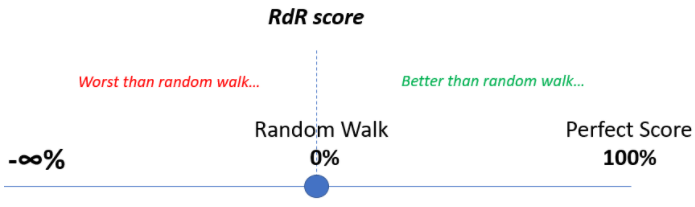

In [36]:
Image(filename='/opt/continuum/data/image/RdRScore.png')

If you want a better explaination of the RdR Score, follow the link bellow:

%%html
<a href="https://medium.com/@dave.cote.msc/rdr-score-metric-for-evaluating-time-series-forecasting-models-1c23f92f80e7">Click Me --> RdR Score on Medium</a>

In [37]:

scorer_benchmark = RdR_scorer()

<a class="anchor" id="P5"></a>
# Section#5 - BiLSTM

In [38]:
class PrintDot(Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('.', end='')

<a class="anchor" id="section5.1"></a>
### 5.1 - BiLSTM Architecture

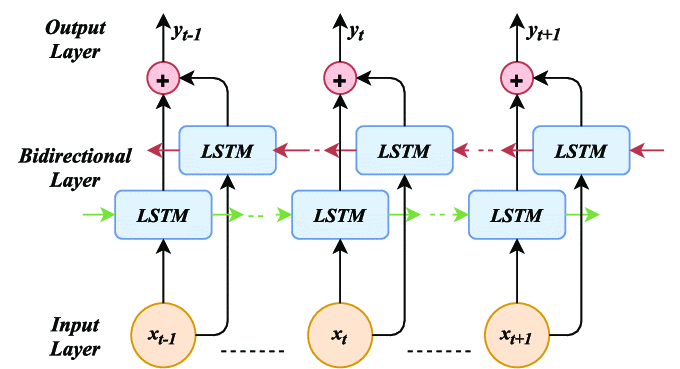

In [39]:
Image(filename='/opt/continuum/data/image/blstm.png')

In [40]:
input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])

def create_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim, 
                                   return_sequences=False, 
                                   kernel_initializer = 'glorot_uniform',
                                   activation = 'tanh'
                                   )))
    model.add(Dense(units=output_dim, activation = 'linear'))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)#, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    
    return model

model = create_BiLSTM()



2022-04-04 17:53:44.972627: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-04-04 17:53:44.972672: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-04 17:53:44.972703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anaconda-session-0642e1b2ba064820b8320b76c6599e10-d47fd44cfjfbq): /proc/driver/nvidia/version does not exist
2022-04-04 17:53:44.973007: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate com

<a class="anchor" id="section5.2"></a>
### 5.2 - BiLSTM Train

In [41]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=10)#4
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 60, 
                    validation_data = (X_train_full[-dict_ts_sequence['n_leads']:,:, :], 
                                       y_train_full[-dict_ts_sequence['n_leads']:,:, :]),
                    #validation_split = 0.1, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])



...

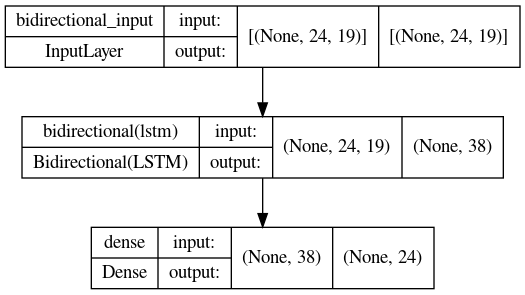

In [42]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [43]:
def plot_learning_curve(history, monitor_label = 'val_loss'):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    min_vec = []
    for i in range(0, len(hist)):
        if i == 0:
            min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
        else:
            if hist[[monitor_label]].iloc[i, :].values[0] < np.min(min_vec):
                min_vec.append(hist[[monitor_label]].iloc[i, :].values[0])
            else:
                min_vec.append(np.min(min_vec))

    hist['best_from_start'] = min_vec
    hist['improved'] = np.where(hist['best_from_start'] == hist[monitor_label], 1, 0)
            

    best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]

    plt.figure(figsize = (18, 9))
    plt.plot(hist[monitor_label], label = monitor_label)
    try:
        plt.plot(hist['loss'], label = 'loss')
    except:
        pass
    #plt.plot(hist[monitor_label], label = 'val_loss')

    plt.scatter(hist[hist['improved'] == 1]['epoch'], hist[hist['improved'] == 1][monitor_label], color = 'green', label = 'Improved')
    plt.legend()
    plt.title('Learning curve'
              '\n' + 'best epoch:' + str(best_epoch) + '(' + str(round(np.min(hist[monitor_label]), 3)) + ')')

max epoch : 262


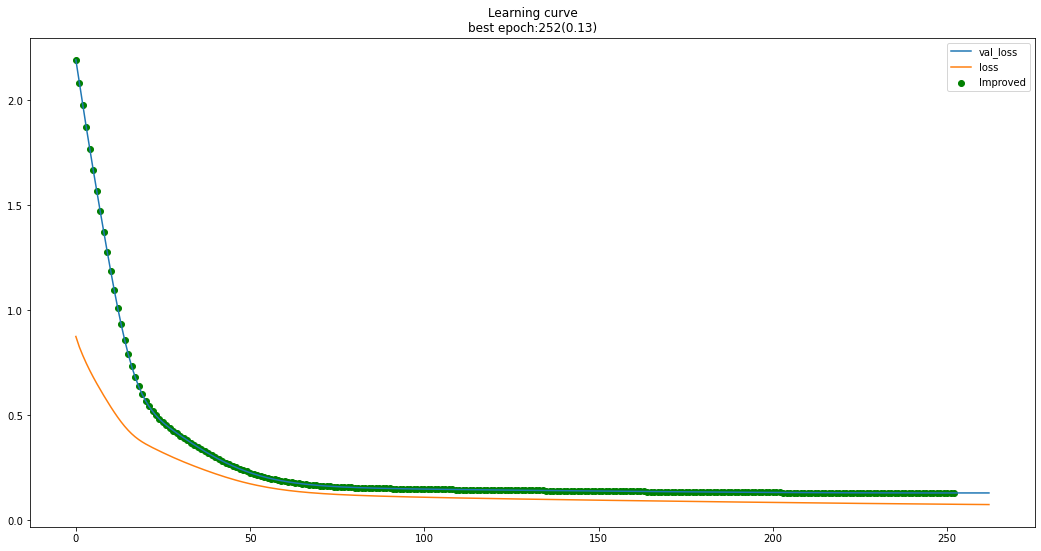

In [44]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section5.3"></a>
### 5.3 - BiLSTM Validation

In [45]:
pred_all = pd.DataFrame(model.predict(X_test_sequence)).T
#pred_scaled = pd.DataFrame(np.mean(model.predict(X_test_sequence), axis = 0))
#pred_scaled = np.mean(pred_scaled, axis = 1)
#pred_all

In [46]:
def inverse_forecast(y_scaler, dict_ts, pred_df):
    pred_df = pd.DataFrame(y_scaler.inverse_transform(pred_df))
    pred_df.columns = ['Y_PRED']
    
    if dict_ts_sequence['stabilize_mean'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['diff_transformer_dict_train'][dict_ts['y_colname']].forecast_transform(pred_df[['Y_PRED']].values)
    if dict_ts_sequence['stabilize_variance'] == True:
        pred_df['Y_PRED'] = dict_ts_sequence['log_transformer_dict_train'][dict_ts['y_colname']].inverse_transform(pred_df[['Y_PRED']].values)
 
    return pred_df

In [47]:
def get_feat_for_scoring(ts, y_scaler, dict_ts, pred_df, model_name):
    
    ts_orig = y_scaler.inverse_transform(ts[dict_ts['y_colname']].values.reshape(-1,1))
    ts_orig = pd.DataFrame(ts_orig, index = ts.index, columns = [dict_ts['y_colname']])
    
    pred_df = inverse_forecast(y_scaler, dict_ts, pred_df)

    y_colname = dict_ts['y_colname']
    n_steps = dict_ts['n_leads']

    #y_true = y_scaler.inverse_transform(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values.reshape(-1,1))   
    y_true = ts.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values.reshape(-1,1)
    y_true = pd.DataFrame(y_true, index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = [dict_ts['y_colname']])
    
    y_pred = pred_df.copy()
    y_pred = pd.DataFrame(y_pred.values.ravel(), index = pd.to_datetime(ts.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), columns = ['Y_PRED'])

    freq = dict_ts['freq']    
  
    return ts, y_colname, n_steps, y_true, y_pred, model_name, freq

In [48]:
ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'BiLSTM')


average_ensemble_model = []
average_ensemble_model.append(y_pred)

In [49]:
scorer_benchmark.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

1970-02-28 00:00:00.000000222 1972-01-31 00:00:00.000000222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


In [50]:
scorer_benchmark.get_df_viz()

DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21937.629965   5351.187911    0.59261      BiLSTM
1  59099.430044  12063.620641    0.00000  RandomWalk

In [51]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

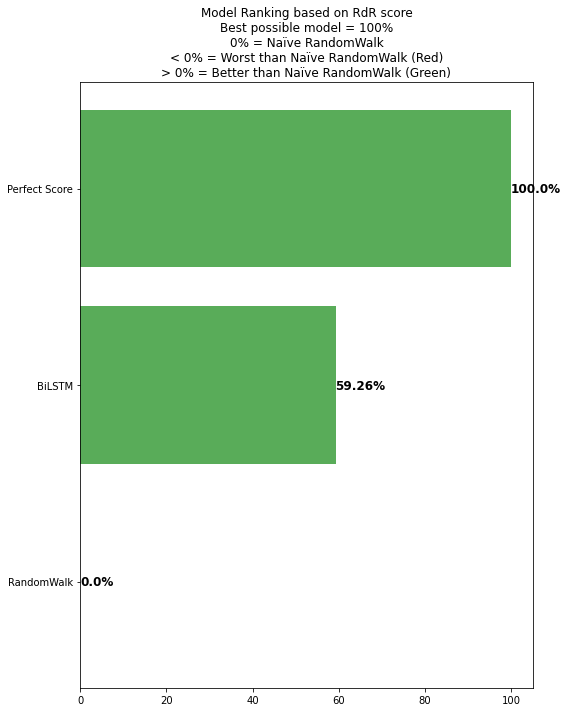

In [52]:
scorer_benchmark.plot_rdr_rank()

In [53]:
def get_pred_dates(freq, X_pred, date_colname, n_leads):
    #ts_sequence_train.index = pd.to_datetime(ts_sequence_train[date_colname])
    if freq == 12:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
    
    elif freq == 52:
        print(X_pred.index)
        print(max(X_pred.index))
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(weeks=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(weeks=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 4:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=3)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(months=i*3) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
    
    elif freq == 2:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(months=6)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i*6) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 1:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(years=1)+ MonthEnd(0) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(years=i) + MonthEnd(0)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq >= 250 and freq <= 368:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(days=1) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(days=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 1638:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=60)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*60) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
            
    elif freq == 3276:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=30) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*30) ])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]   
    
    elif freq == 6552:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=15) ])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*15)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 9828:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=10)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*10)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    elif freq == 19656:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=5)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i*5)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]    
            
    elif freq == 98280:
        X_pred_date = pd.DataFrame([max(X_pred.index) + relativedelta(minutes=1)])
        if n_leads >= 2:
            for i in range(2, n_leads+1):
                X_pred_date = X_pred_date.append([max(X_pred.index) + relativedelta(minutes=i)])    
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]             
        else:
            X_pred_date.columns = [date_colname] 
            X_pred_date.index = X_pred_date[date_colname]  
            
    return X_pred_date

In [54]:
def plot_results(ts_train, ts_full, pred_df, y_scaler, forecast, y_scaler_forecast, dict_ts):

    fig, ax = plt.subplots(figsize = (12,8))
    #ax.plot(pd.to_datetime(ts_train.index), 
            #ts_train[dict_ts['y_colname']].values.reshape(-1,1))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),  
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
            pred_df.values.ravel(), label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    plt.title('Validation: True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
        pred_df.values.ravel())
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
        ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values)
    plt.title('Validation (Zoomed): True vs MultiStep Forecast')
    plt.legend()

    fig, ax = plt.subplots(figsize = (12,8))
    #ax.plot(pd.to_datetime(ts_train.index), 
            #ts_train[dict_ts['y_colname']].values.reshape(-1,1))
    ax.plot(pd.to_datetime(ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['date_colname']]),  
            ts_full.iloc[:-dict_ts['n_leads'], :][dict_ts['y_colname']].values, label = 'HISTORICAL')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]),  
            pred_df.values.ravel(), label = 'PRED_TEST')
    ax.plot(pd.to_datetime(ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['date_colname']]), 
            ts_full.iloc[-dict_ts['n_leads']:, :][dict_ts['y_colname']].values, label = 'TRUE_TEST')
    ax.plot(forecast.index, 
            forecast['Y_PRED'].values.ravel(), label = 'FORECAST')
    plt.title('MultiStep Forecast - ' + model_name)
    plt.legend()


<a class="anchor" id="section5.4"></a>
### 5.4 - BiLSTM Forecast

In [55]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=100)#4


model = create_BiLSTM()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 100, 
                    #validation_data=(X_test, Y_test)
                    #validation_split = 0.1, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(X_forecast))
pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())


pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

ts_sequence_train.index = pd.to_datetime(ts_sequence_train[dict_ts_sequence['date_colname']])
ts_sequence.index = pd.to_datetime(ts_sequence[dict_ts_sequence['date_colname']])

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast = []
average_ensemble_model_forecast.append(pred_forecast)

......

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


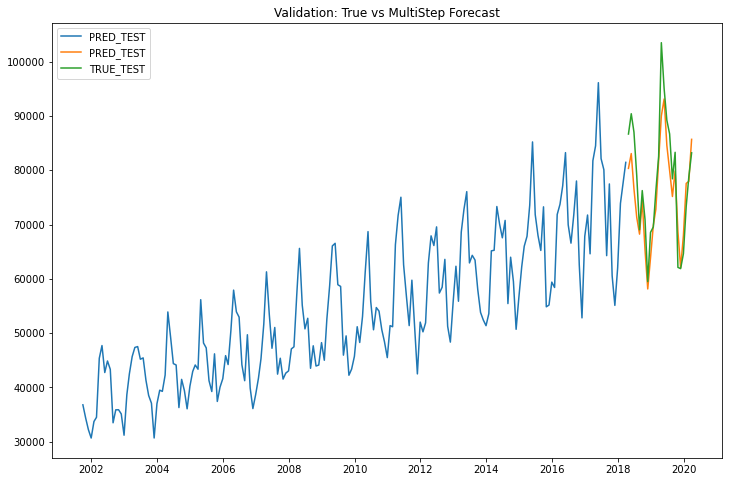

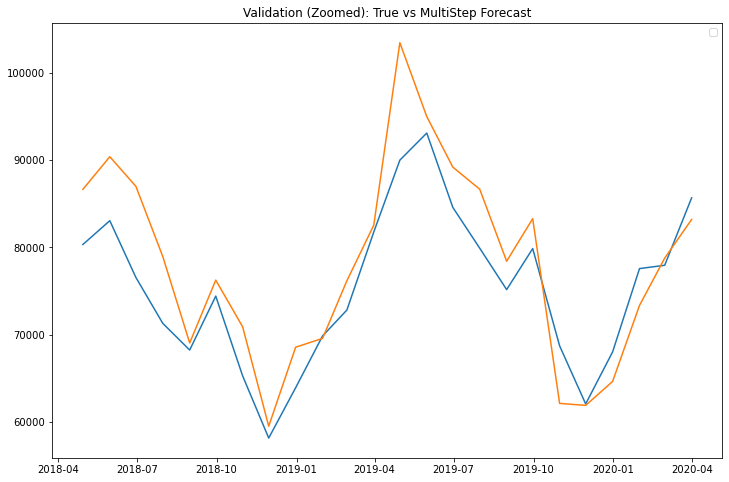

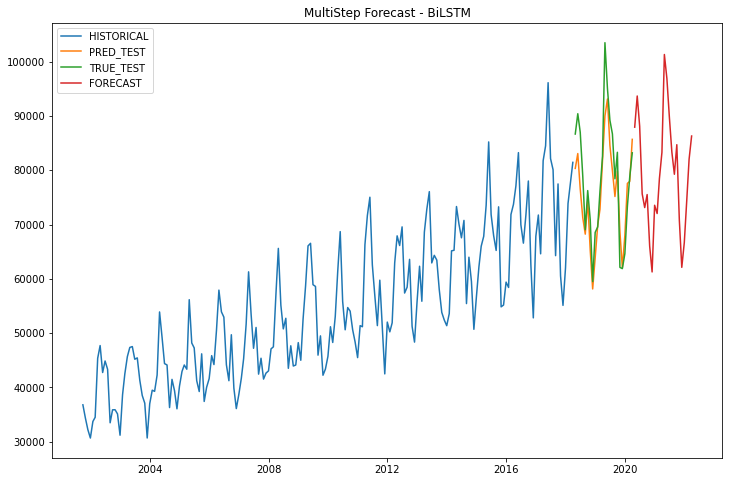

In [56]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

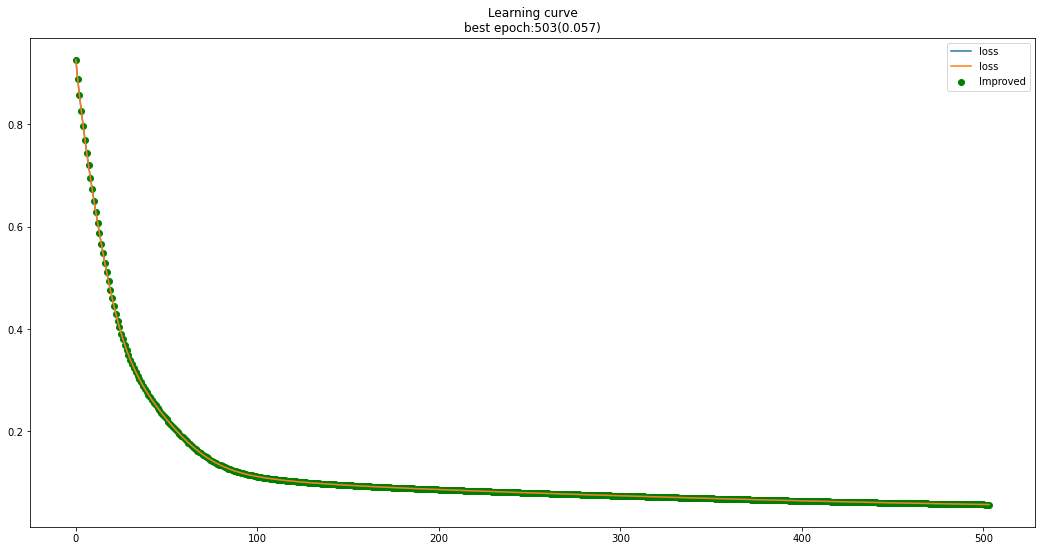

In [57]:
plot_learning_curve(history, monitor_label = 'loss')

<a class="anchor" id="P6"></a>
# Section#6 - Seq2Seq

<a class="anchor" id="section6.1"></a>
### 6.1 - Seq2Seq Architecture

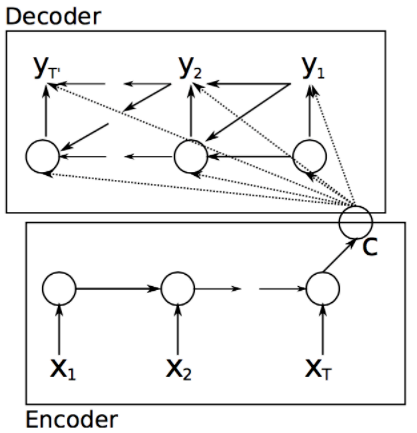

In [58]:
Image(filename='/opt/continuum/data/image/encoder_decoder.png')

In [59]:
input_dim = int(X_train_sequence.shape[2])
output_dim = int(y_train_sequence.shape[1])
n_samples = len(X_train_sequence)

def create_seq2seq():
    model = Sequential()
    # Encoder
    model.add(LSTM(units=input_dim, return_sequences=False, activation = 'tanh'))
    model.add(Dense(150, activation="relu") )
    #Use "RepeatVector" to copy N copies of Encoder's output (last time step) as Decoder's N inputs
    model.add(RepeatVector(output_dim))
    # Decoder (second LSTM) 
    model.add(LSTM(units=input_dim, activation = 'tanh', return_sequences=True) )
    # TimeDistributed is to ensure consistency between Dense and Decoder
    model.add(TimeDistributed(Dense(output_dim, activation="linear")) )

    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    return model

model = create_seq2seq()

<a class="anchor" id="section6.2"></a>
### 6.2 - Seq2Seq Train

In [60]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24,#36, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :],
                                      ),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

....

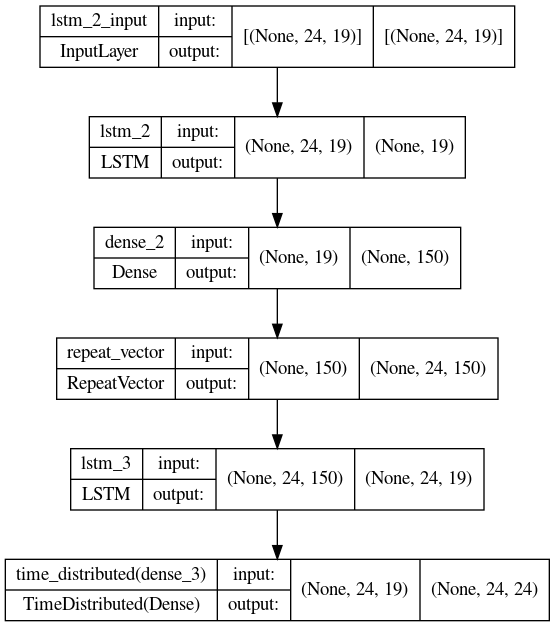

In [61]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 382


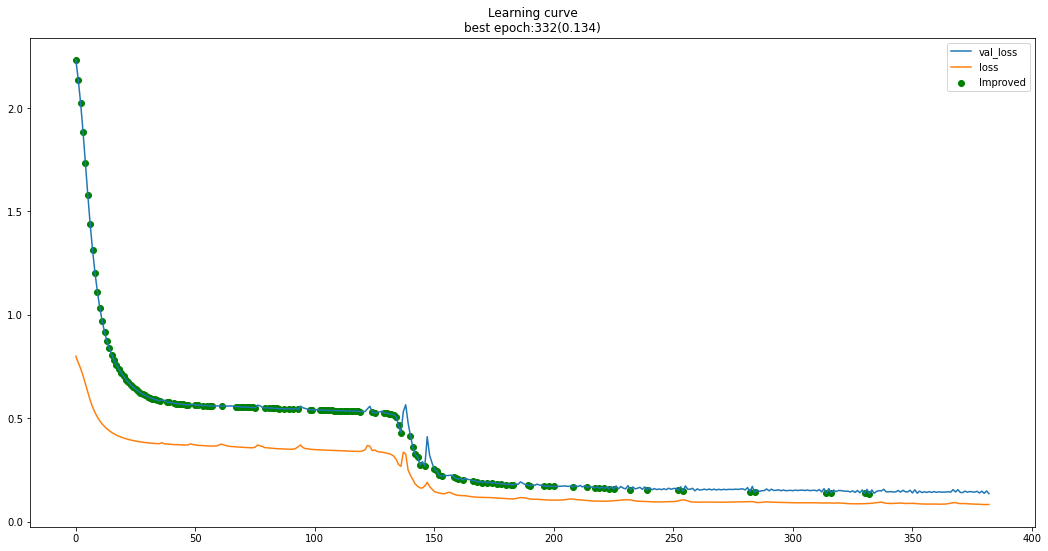

In [62]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section6.3"></a>
### 6.3 - Seq2Seq Validation

In [63]:
pred_scaled = pd.DataFrame(model.predict(X_test_sequence)[0,:].T)
pred_all = pd.DataFrame(np.mean(pred_scaled.T, axis = 1))
#pred_all = pd.DataFrame(pred_scaled)
pred_all.columns = ['Y_PRED']

In [64]:
scorer_seq2seq = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Seq2Seq')

average_ensemble_model.append(y_pred)

scorer_seq2seq.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
#scorer_seq2seq.get_df_viz()
scorer_benchmark.add_rdr(scorer_seq2seq)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21937.629965   5351.187911   0.592610      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  30066.735269   8036.460616   0.412539     Seq2Seq

In [65]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

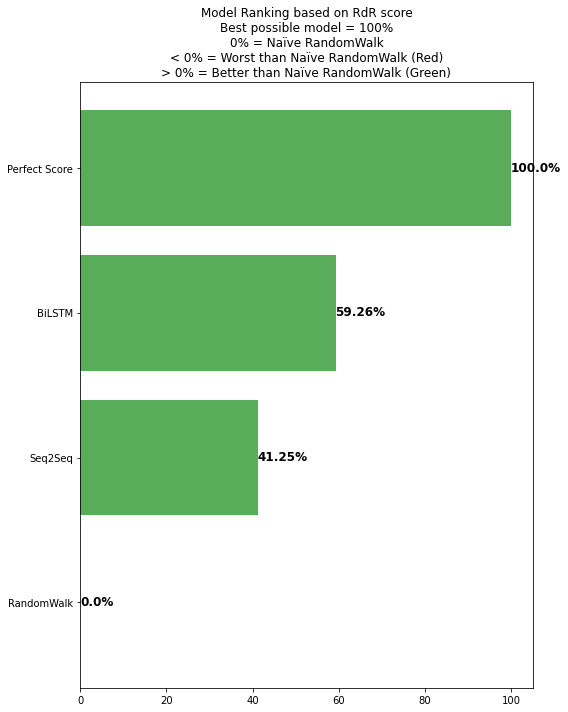

In [66]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section6.4"></a>
### 6.4 - Seq2Seq Forecast

In [67]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_seq2seq()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 24,#36, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(X_forecast)[0,:].T)
pred_forecast = pd.DataFrame(np.mean(pred_fscaled.T, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)

    
X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)


.....

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


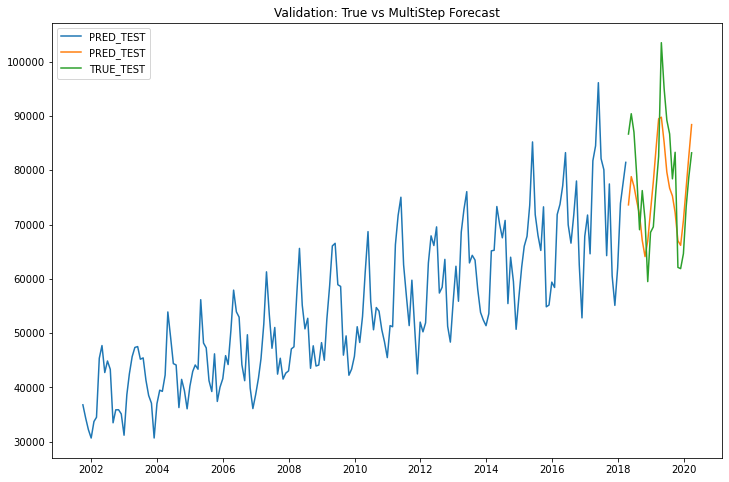

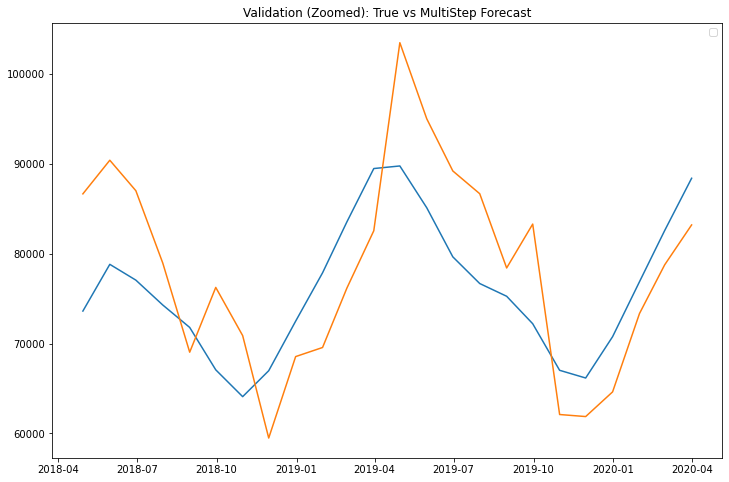

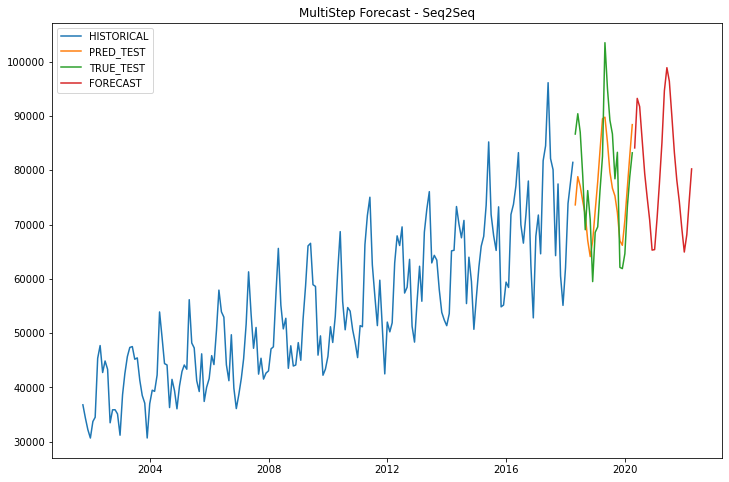

In [68]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

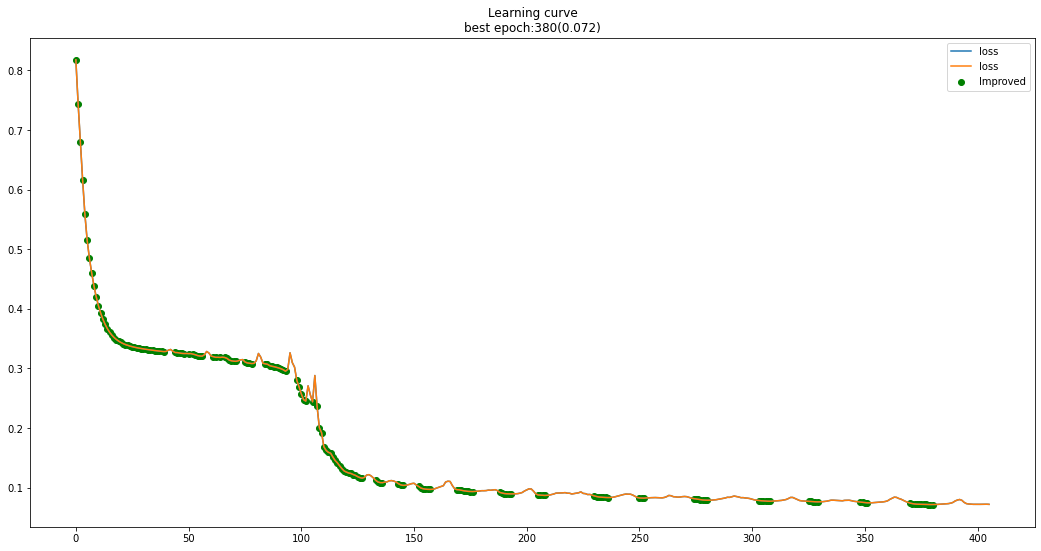

In [69]:
plot_learning_curve(history, monitor_label = 'loss')

<a class="anchor" id="P7"></a>
# Section#7 - CNN-BiLSTM

<a class="anchor" id="section7.1"></a>
### 7.1 - CNN-BiLSTM Architecture

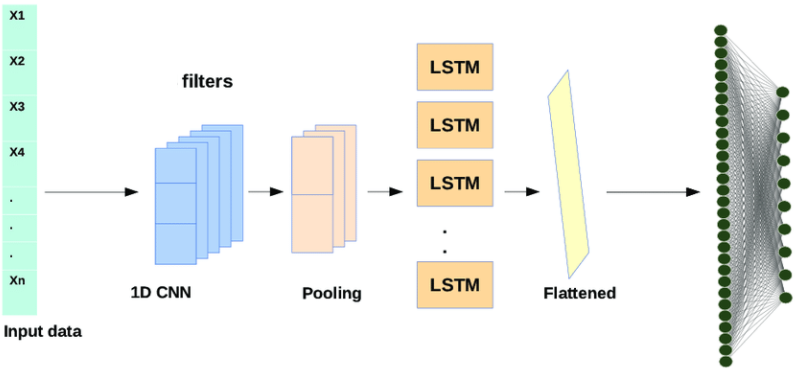

In [70]:
Image(filename='/opt/continuum/data/image/CNN-LSTM2.png')

In [71]:
X_train_cnn = X_train_sequence.reshape(X_train_sequence.shape[0],
                                    X_train_sequence.shape[1],
                                    X_train_sequence.shape[2],
                                    1)

X_train_full_cnn = X_train_full.reshape(X_train_full.shape[0],
                                    X_train_full.shape[1],
                                    X_train_full.shape[2],
                                    1)

def create_cnn_BiLSTM():
    model = Sequential() 
    #model.add(TimeDistributed(Conv1D(filters=256, kernel_size=4, activation='tanh')))
    model.add(TimeDistributed(Conv1D(filters=128, kernel_size=4, activation='tanh')))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='tanh')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(GlobalMaxPool1D())) 
    model.add(Bidirectional(LSTM(input_dim, return_sequences=True, activation = 'tanh')))
    model.add(TimeDistributed(Dense(output_dim, activation = 'linear')))

    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt)
    return model

model = create_cnn_BiLSTM()

<a class="anchor" id="section7.2"></a>
### 7.2 - CNN-BiLSTM Train

In [72]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)
history = model.fit(X_train_cnn, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 6, 
                    validation_data = (X_train_full_cnn[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

......

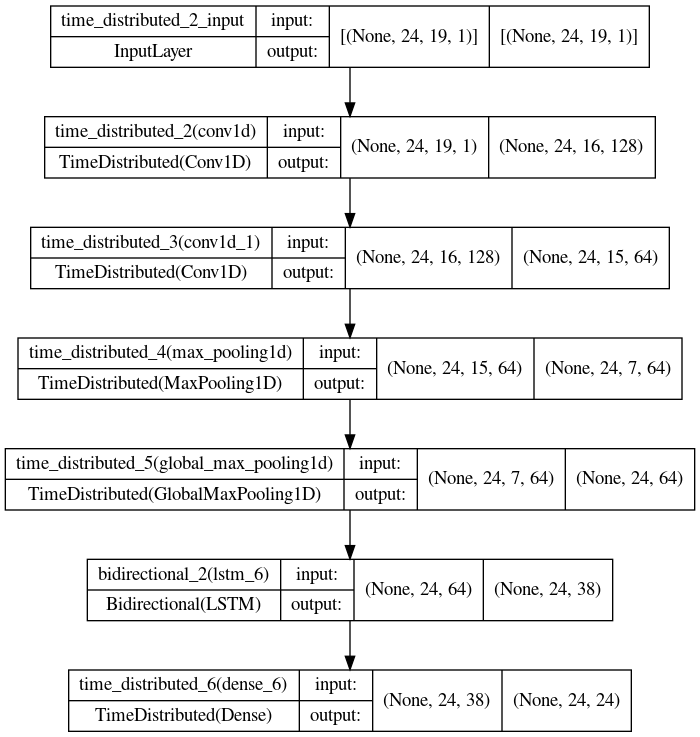

In [73]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 515


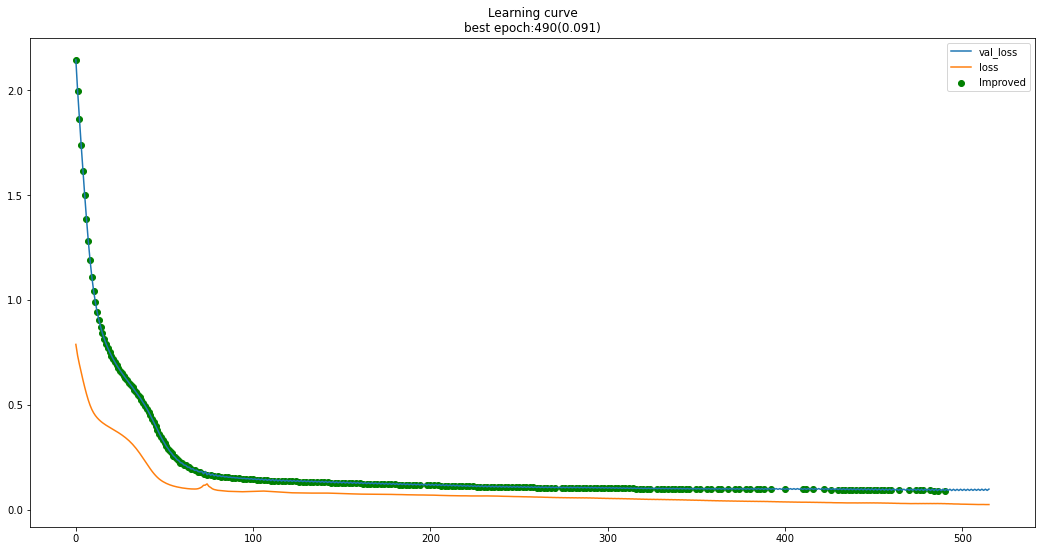

In [74]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section7.3"></a>
### 7.3 - CNN-BiLSTM Validation

In [75]:
X_test_cnn = X_test_sequence.reshape(X_test_sequence.shape[0],
                                    X_test_sequence.shape[1],
                                    X_test_sequence.shape[2],
                                    1)

pred_scaled = pd.DataFrame(np.mean(model.predict(X_test_cnn), axis = 0))
pred_all = pd.DataFrame(np.mean(pred_scaled, axis = 1))
#pred_scaled = pd.DataFrame(model.predict(X_test_cnn))        
#pred_all = pd.DataFrame(pred_scaled.T)


pred_all.columns = ['Y_PRED']

In [76]:
scorer_cnnlstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'CNN-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_cnnlstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_cnnlstm.score())
scorer_benchmark.add_rdr(scorer_cnnlstm)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.6376688319731626


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21937.629965   5351.187911   0.592610      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  30066.735269   8036.460616   0.412539     Seq2Seq
3  20040.350093   4651.332182   0.637669  CNN-BiLSTM

In [77]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

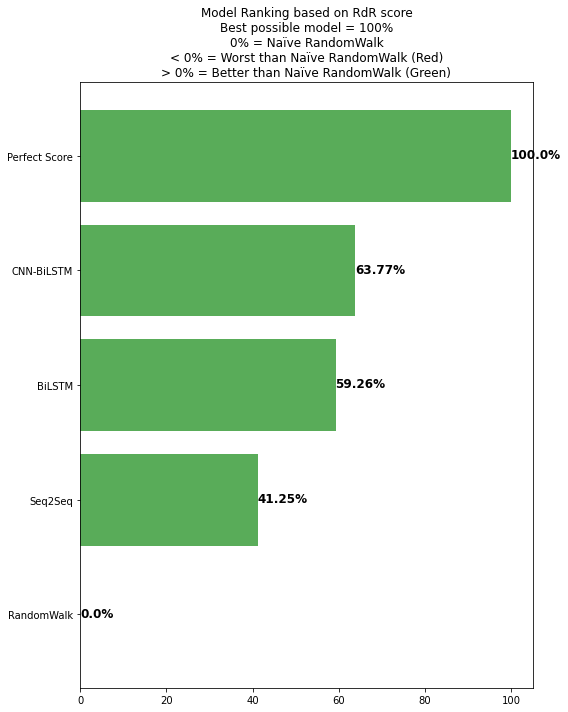

In [78]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section7.4"></a>
### 7.4 - CNN-BiLSTM Forecast

In [79]:
X_train_full_cnn = X_train_full.reshape(X_train_full.shape[0],
                                    X_train_full.shape[1],
                                    X_train_full.shape[2],
                                    1)

X_forecast_cnn = X_forecast.reshape(X_forecast.shape[0],
                                    X_forecast.shape[1],
                                    X_forecast.shape[2],
                                    1)

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_cnn_BiLSTM()

history = model.fit(X_train_full_cnn, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 6, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast_cnn))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast_cnn), axis = 0))
pred_forecast = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


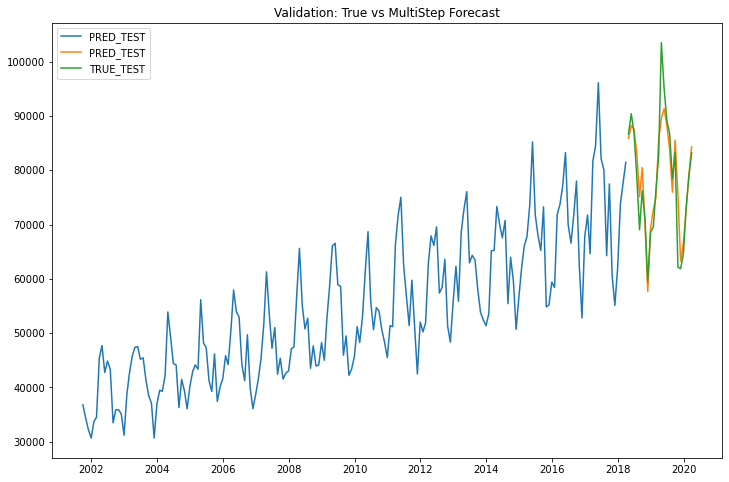

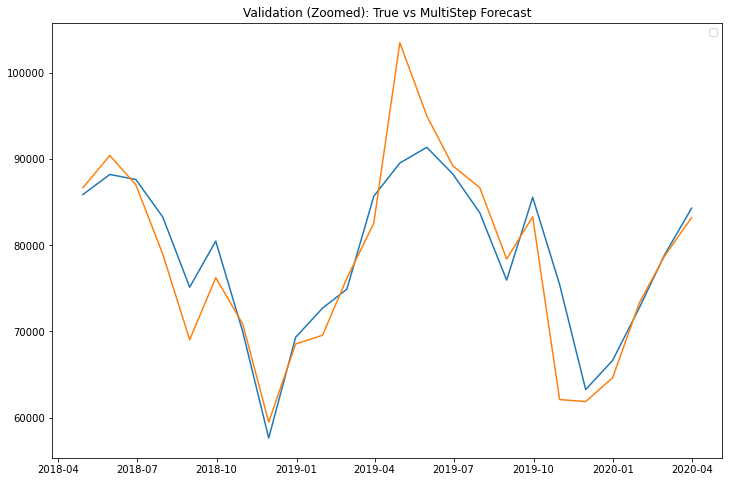

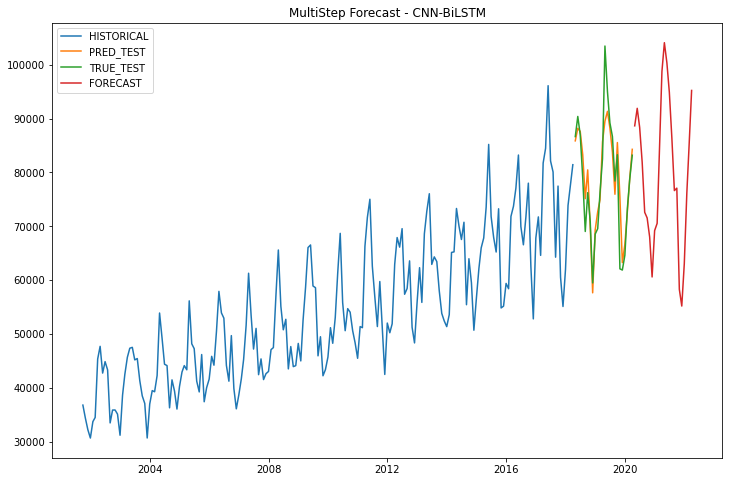

In [80]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

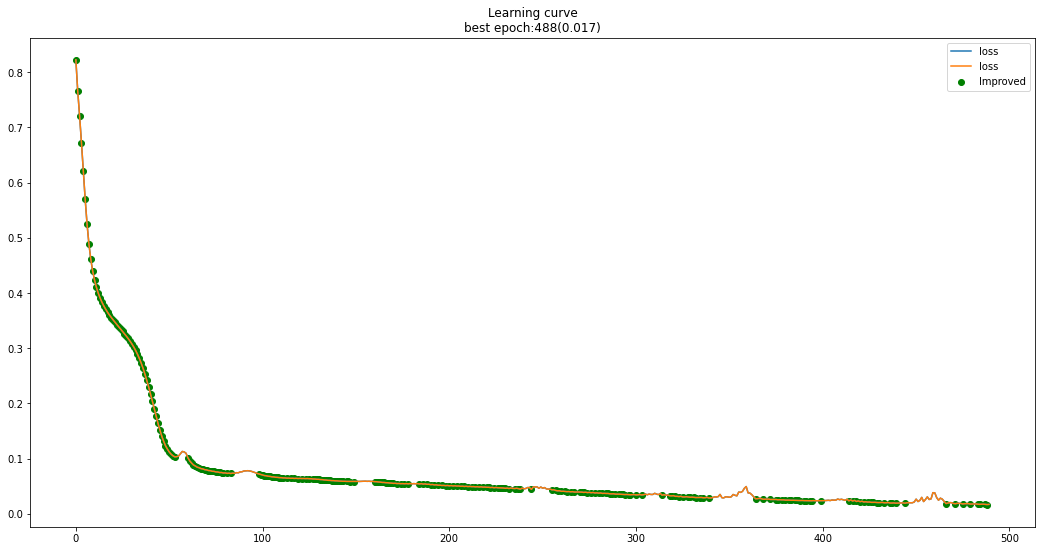

In [81]:
plot_learning_curve(history, 'loss')

<a class="anchor" id="P8"></a>
# Section#8 - TCN-BiLSTM

<a class="anchor" id="section8.1"></a>
### 8.1 - TCN-BiLSTM Architecture

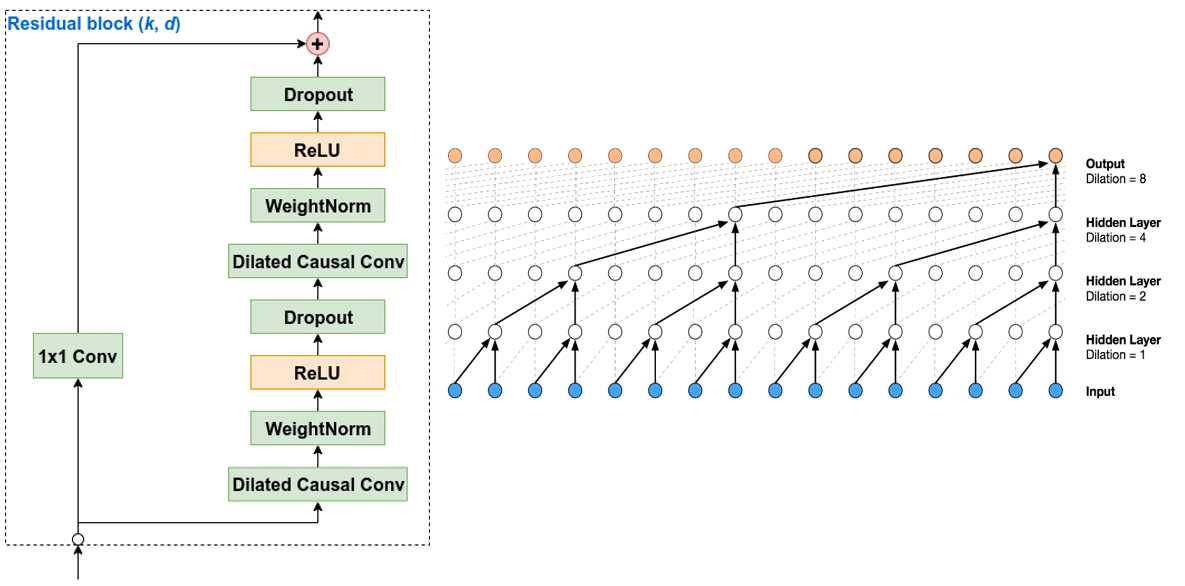

In [82]:
Image(filename='/opt/continuum/data/image/TCN.png')

In [83]:
def create_tcn():
    i = Input(shape=(X_train_sequence.shape[1], X_train_sequence.shape[2]))
    m = TCN(nb_filters=32,
                     kernel_size=16,
                     nb_stacks=4,
                     dilations=(2, 4, 8, 16, 32, 64),
                     padding='causal',
                     use_skip_connections=True,
                     dropout_rate=0.0,
                     activation='tanh',
                     kernel_initializer='glorot_uniform',
                     use_batch_norm=False,
                     use_layer_norm=False,
                     use_weight_norm=False,
            return_sequences = True)(i)
    m = Bidirectional(LSTM(input_dim, return_sequences=False, activation = 'tanh'))(m)
    #m = TimeDistributed(Dense(output_dim, activation = 'linear'))(m)
    m = Dense(y_train_sequence.shape[1], activation='linear')(m)

    model = Model(inputs=[i], outputs=[m])

    model.summary()
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=opt)

    return model

model = create_tcn()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 tcn (TCN)                   (None, 24, 32)            781952    
                                                                 
 bidirectional_4 (Bidirectio  (None, 38)               7904      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 24)                936       
                                                                 
Total params: 790,792
Trainable params: 790,792
Non-trainable params: 0
_________________________________________________________________


<a class="anchor" id="section8.2"></a>
### 8.2 - TCN-BiLSTM Train

In [84]:
#model = create_tcn()

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=450, 
                    batch_size =4, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

...

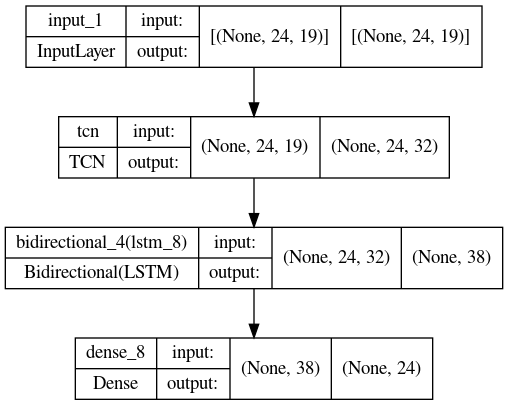

In [85]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 208


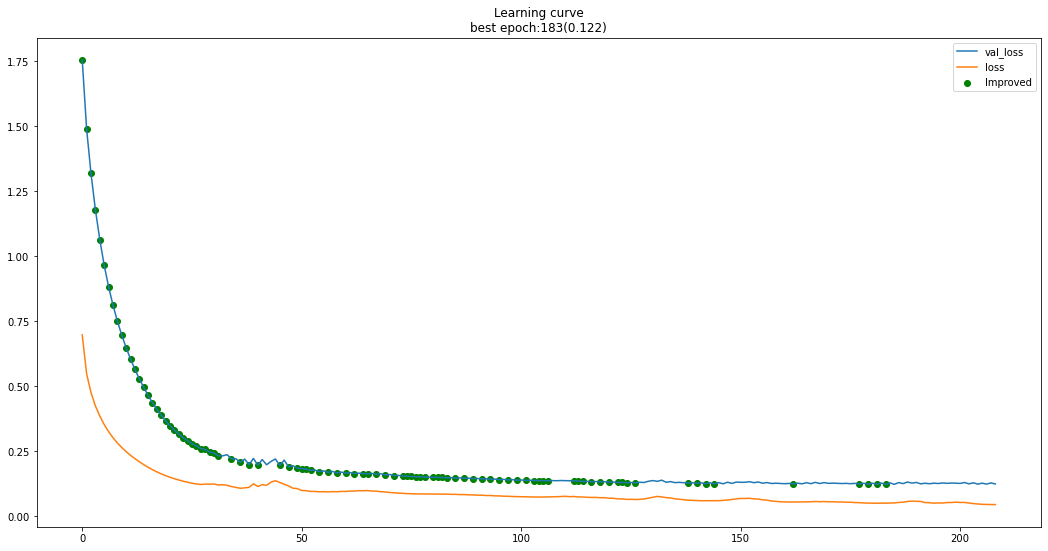

In [86]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section8.3"></a>
### 8.3 - TCN-BiLSTM Validation

In [87]:
pred_scaled = model.predict(X_test_sequence).ravel()
pred_scaled

array([1.8579056 , 2.22487   , 1.5790942 , 1.4064312 , 1.48522   ,
       1.3490433 , 0.8859636 , 0.5243969 , 0.98240775, 1.7037219 ,
       1.4186049 , 1.9642513 , 2.2242851 , 2.4641852 , 2.4143498 ,
       2.073685  , 1.6542667 , 1.794762  , 0.91370803, 0.48721233,
       0.83579564, 1.6904544 , 1.5803787 , 2.7392173 ], dtype=float32)

In [88]:
pred_all = pd.DataFrame(pred_scaled)
pred_all.columns = ['Y_PRED']

In [89]:
scorer_seq2seq = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'TCN-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_seq2seq.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
#scorer_seq2seq.get_df_viz()
scorer_benchmark.add_rdr(scorer_seq2seq)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21937.629965   5351.187911   0.592610      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  30066.735269   8036.460616   0.412539     Seq2Seq
3  20040.350093   4651.332182   0.637669  CNN-BiLSTM
4  27388.128570   6808.907050   0.486079  TCN-BiLSTM

In [90]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

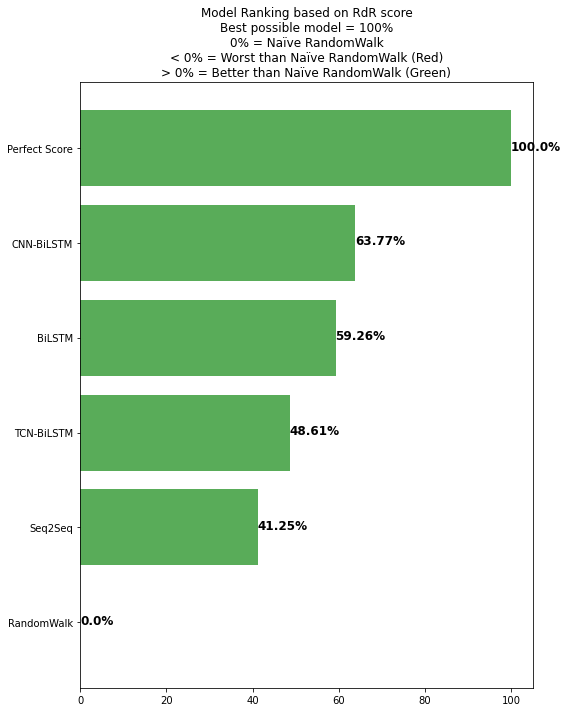

In [91]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section8.4"></a>
### 8.4 - TCN-BiLSTM Forecast

In [92]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_tcn()

history = model.fit(X_train_full_cnn, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size =4, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast_cnn))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = model.predict(X_test_sequence).ravel()
pred_forecast = pd.DataFrame(pred_fscaled)

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 tcn_1 (TCN)                 (None, 24, 32)            781952    
                                                                 
 bidirectional_5 (Bidirectio  (None, 38)               7904      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 24)                936       
                                                                 
Total params: 790,792
Trainable params: 790,792
Non-trainable params: 0
_________________________________________________________________
.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


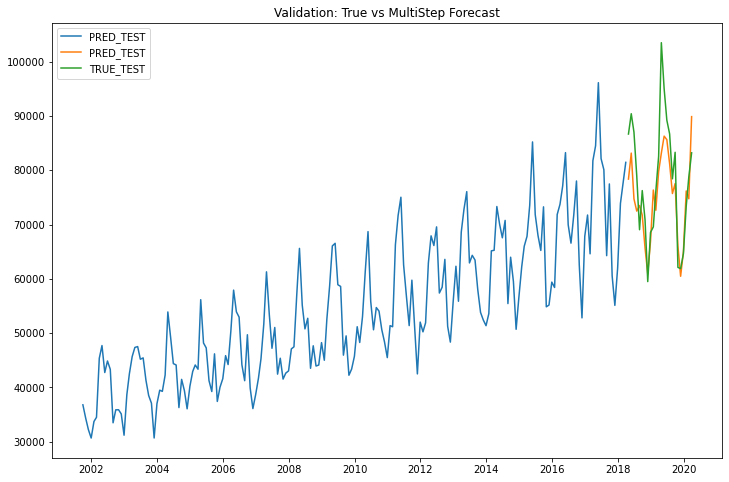

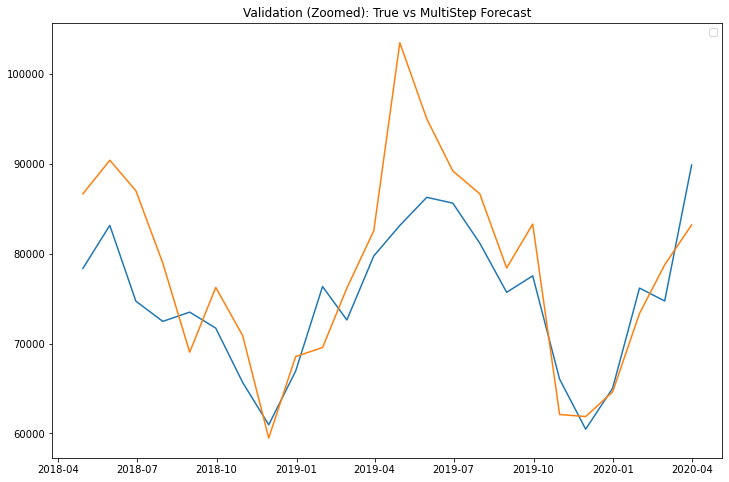

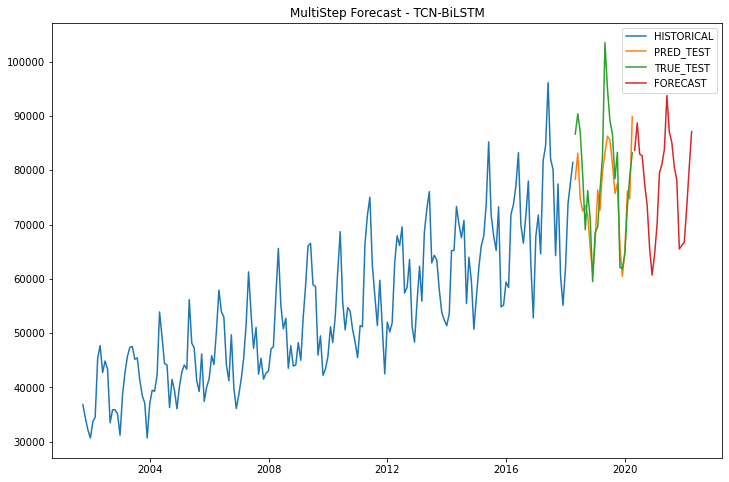

In [93]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

<a class="anchor" id="P9"></a>
# Section#9 - MDN-BiLSTM

<a class="anchor" id="section9.1"></a>
### 9.1 - MDN-BiLSTM Architecture

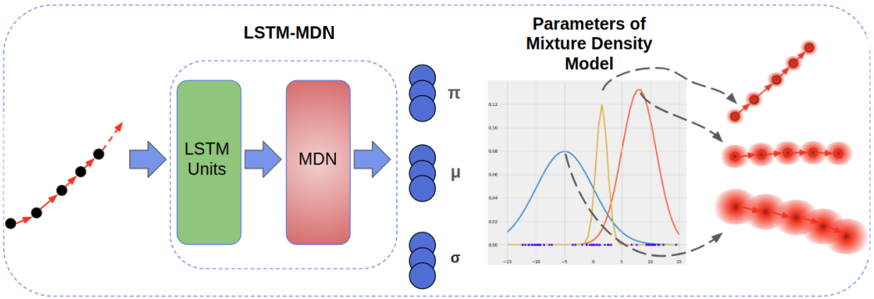

In [94]:
Image(filename='/opt/continuum/data/image/MDN-LSTM2.png')

In [95]:
n_mixtures = 5
def create_mdn_BiLSTM(n_mixtures = n_mixtures):
    
    model = Sequential()

    model.add(Bidirectional(LSTM(units=input_dim, 
                                 return_sequences=False, 
                                 kernel_initializer = 'normal',
                                 activation = 'tanh'
                                 )))
    model.add(Dense(250, activation = 'tanh'))
    model.add(MDN(output_dim, n_mixtures))

    #opt = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=get_mixture_loss_func(output_dim, n_mixtures), optimizer=opt)
    return model

model = create_mdn_BiLSTM()

<a class="anchor" id="section9.2"></a>
### 9.2 - MDN-BiLSTM Train

In [96]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=18)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=450, 
                    batch_size = 100, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
...

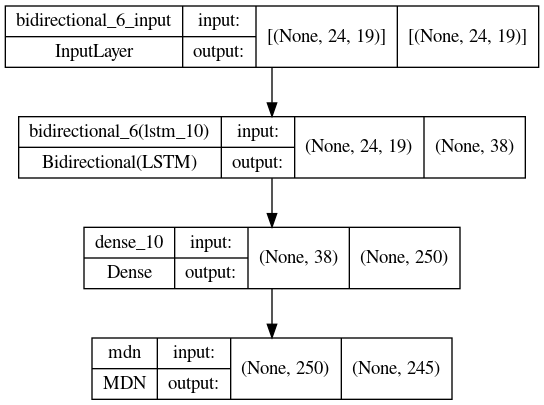

In [97]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 271


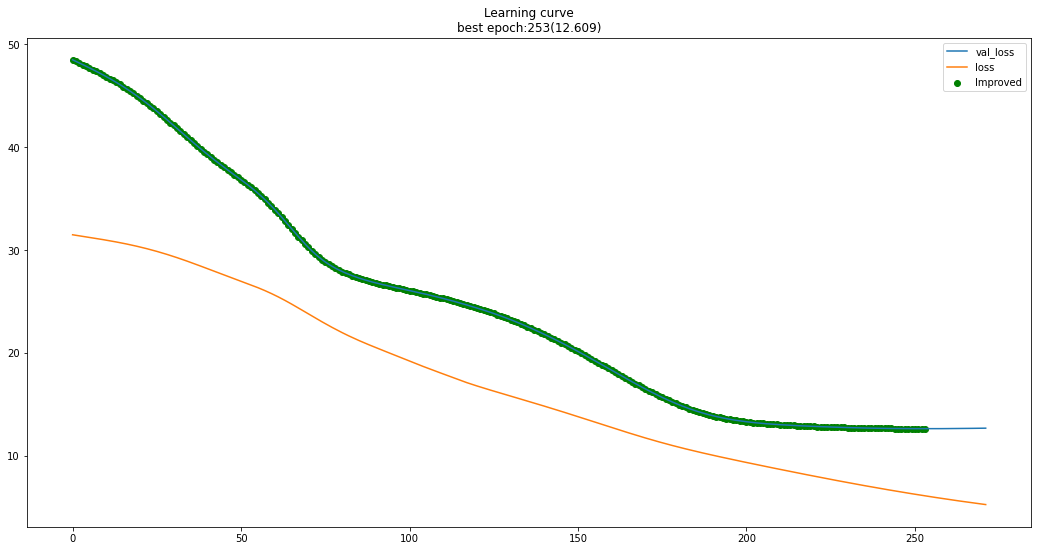

In [98]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section9.3"></a>
### 9.3 - MDN-BiLSTM Validation

In [99]:
pred_scaled = model.predict(X_test_sequence)

In [100]:
pred_dist = []
for i in range(0, 10001):
    y_samples = np.apply_along_axis(sample_from_output, 1, pred_scaled, output_dim, n_mixtures, temp=1.0)
    pred_dist.append(y_samples[0].ravel())

pred_dist = pd.DataFrame(pred_dist)  

pred_scaled = pd.DataFrame(np.mean(pred_dist, axis = 0))
pred_all =  pred_scaled.copy()

pred_all.columns = ['Y_PRED']

In [101]:
scorer_mdnstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'MDN-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_mdnstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_mdnstm.score())
scorer_benchmark.add_rdr(scorer_mdnstm)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.4647588071835608


DTW          RMSE  RdR_SCORE  MODEL_NAME
0  21937.629965   5351.187911   0.592610      BiLSTM
1  59099.430044  12063.620641   0.000000  RandomWalk
2  30066.735269   8036.460616   0.412539     Seq2Seq
3  20040.350093   4651.332182   0.637669  CNN-BiLSTM
4  27388.128570   6808.907050   0.486079  TCN-BiLSTM
5  29632.681845   6865.147551   0.464759  MDN-BiLSTM

In [102]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

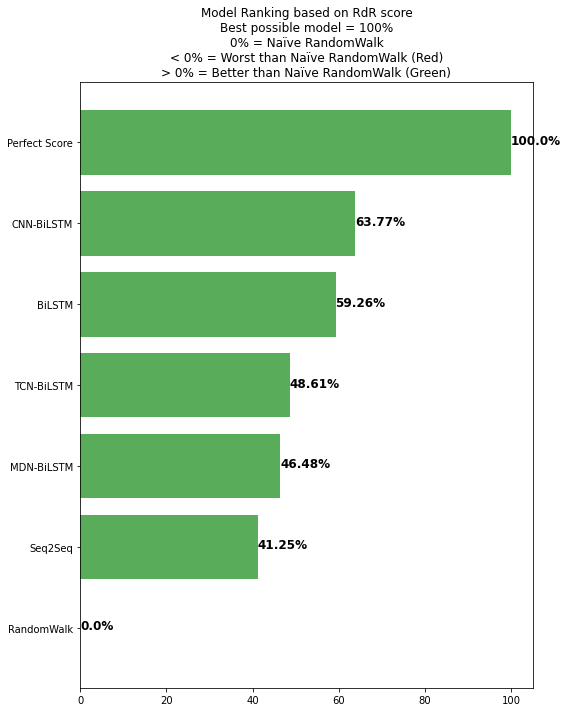

In [103]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section9.4"></a>
### 9.4 - MDN-BiLSTM Forecast

In [104]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_mdn_BiLSTM()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 100, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

......

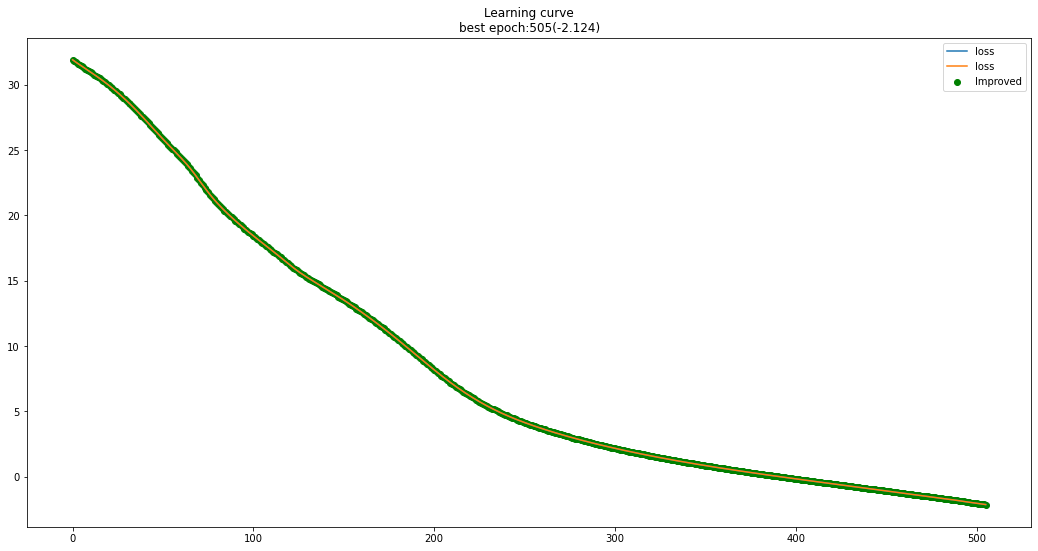

In [105]:
plot_learning_curve(history, 'loss')

In [106]:
pred_fscaled = model.predict(X_forecast)
        
pred_dist = []
for i in range(0, 10001):
    y_samples = np.apply_along_axis(sample_from_output, 1, pred_fscaled, output_dim, n_mixtures, temp=1.0)
    pred_dist.append(y_samples[0].ravel())

pred_dist = pd.DataFrame(pred_dist)  

pred_fscaled = pd.DataFrame(np.mean(pred_dist, axis = 0))
pred_forecast =  pred_fscaled.copy()

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


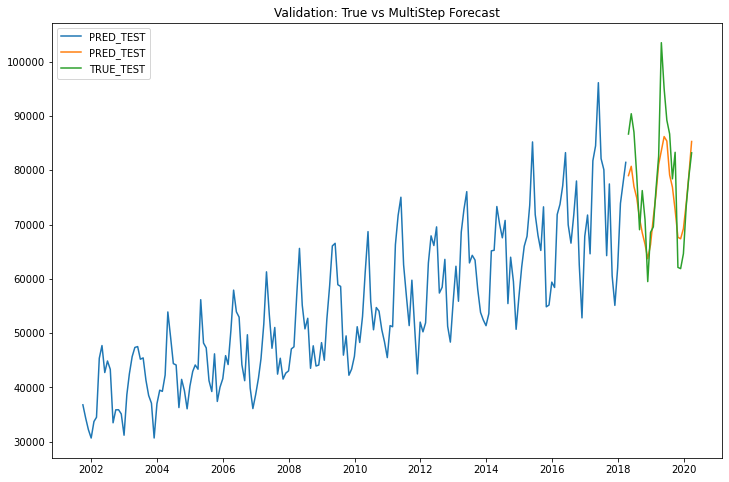

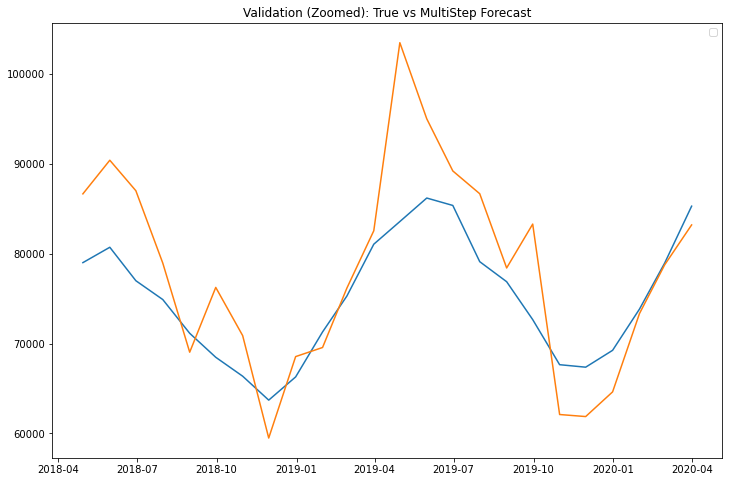

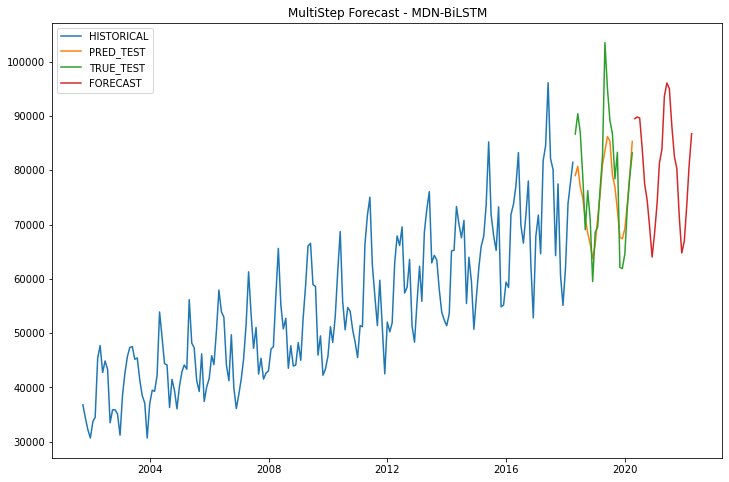

In [107]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

<a class="anchor" id="P10"></a>
# Section#10 - Attention-BiLSTM

<a class="anchor" id="section10.1"></a>
### 10.1 - Attention-BiLSTM Architecture

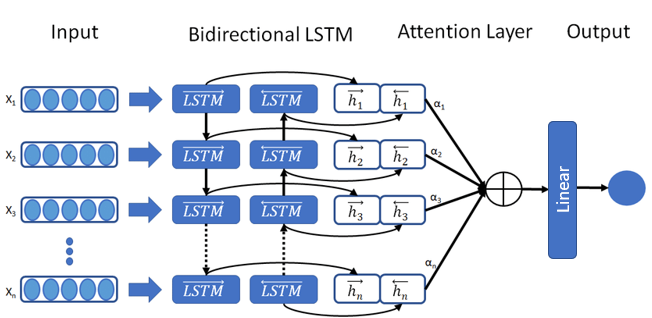

In [108]:
Image(filename='/opt/continuum/data/image/Attention-LSTM.png')

In [109]:

def create_attention_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim, 
                                 return_sequences=True, 
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 )))
    model.add(SeqSelfAttention(attention_activation = 'linear'))
    model.add(TimeDistributed(Dense(units=output_dim, activation = None)))

    #opt = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=True)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0005)#, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    return model

model = create_attention_BiLSTM()

<a class="anchor" id="section10.2"></a>
### 10.2 - Attention-BiLSTM Train

In [110]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=12)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 6, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

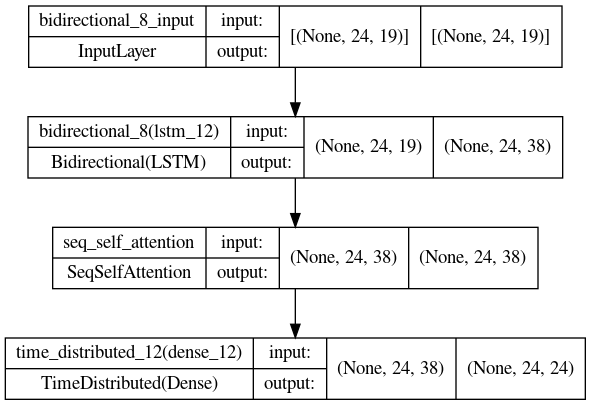

In [111]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 108


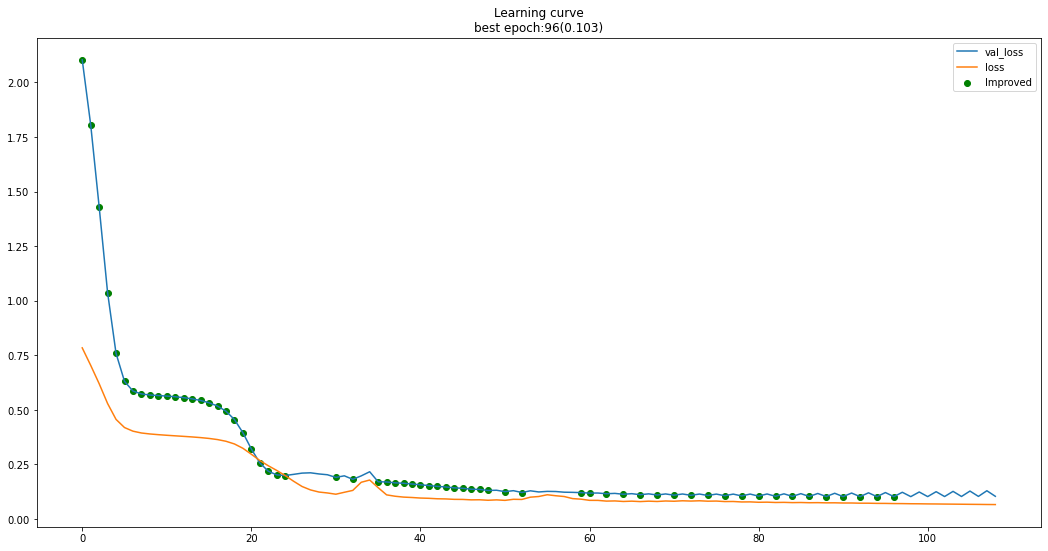

In [112]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section10.3"></a>
### 10.3 - Attention-BiLSTM Validation

In [113]:
#pred_scaled = pd.DataFrame(model.predict(X_test_sequence))
pred_scaled = pd.DataFrame(np.mean(model.predict(X_test_sequence), axis = 0))
pred_all = pd.DataFrame(np.mean(pred_scaled, axis = 1))

In [114]:
#pred_all = pd.DataFrame(pred_scaled.T)
pred_all.columns = ['Y_PRED']

In [115]:
scorer_att = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Attention-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_att.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

scorer_benchmark.add_rdr(scorer_att)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


DTW          RMSE  RdR_SCORE        MODEL_NAME
0  21937.629965   5351.187911   0.592610            BiLSTM
1  59099.430044  12063.620641   0.000000        RandomWalk
2  30066.735269   8036.460616   0.412539           Seq2Seq
3  20040.350093   4651.332182   0.637669        CNN-BiLSTM
4  27388.128570   6808.907050   0.486079        TCN-BiLSTM
5  29632.681845   6865.147551   0.464759        MDN-BiLSTM
6  25059.605736   6777.949527   0.507063  Attention-BiLSTM

In [116]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

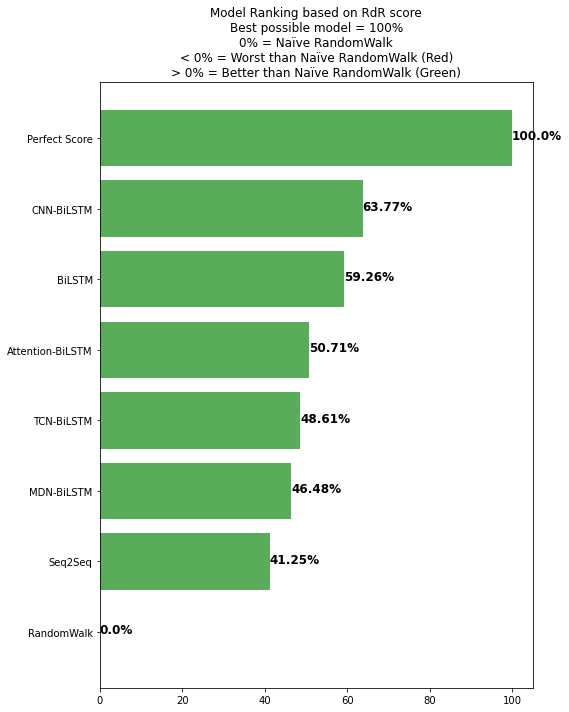

In [117]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section10.4"></a>
### 10.4 - Attention-BiLSTM Forecast

In [118]:

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=16)

model = create_attention_BiLSTM()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 6, 
                    
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


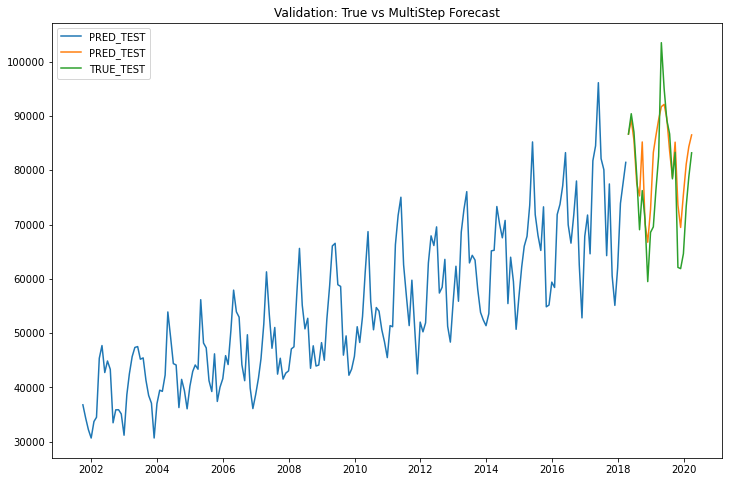

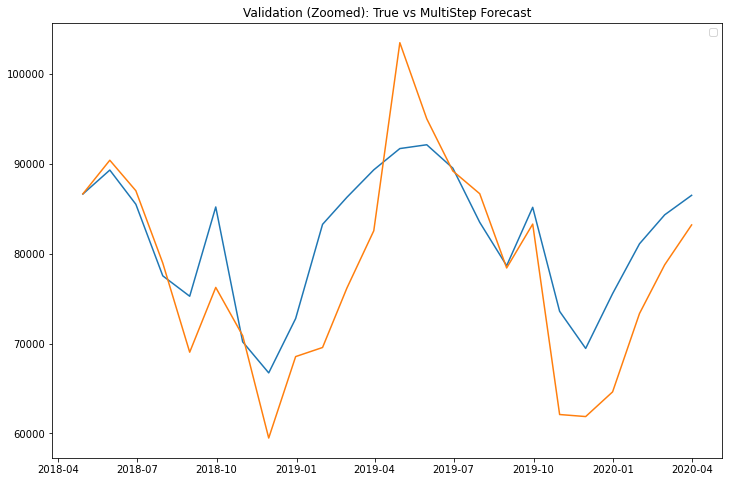

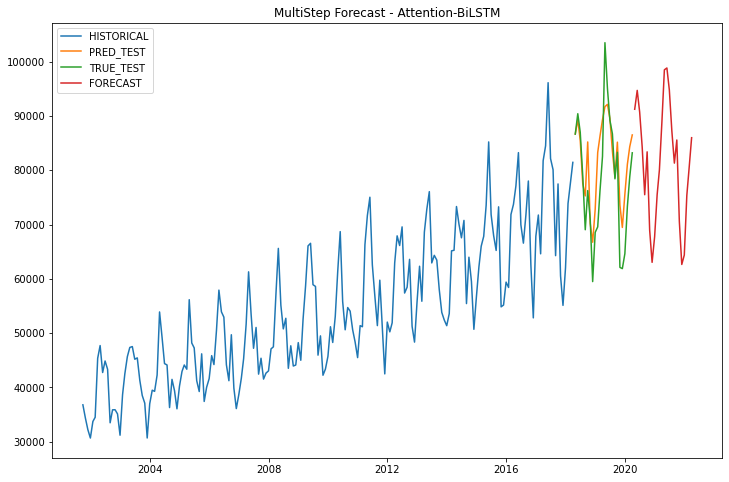

In [119]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

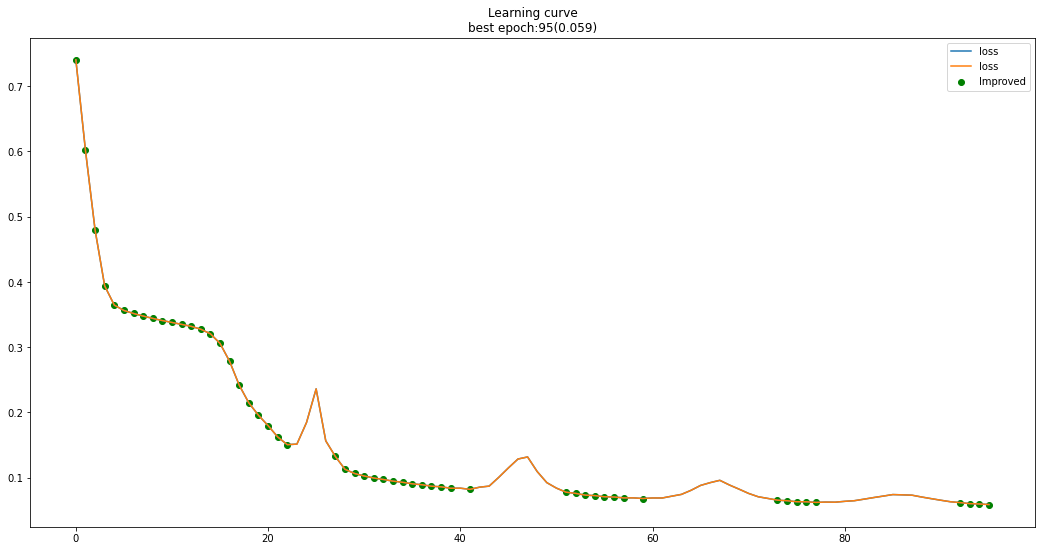

In [120]:
plot_learning_curve(history, 'loss')

<a class="anchor" id="P11"></a>
# Section#11 - Seq2SeqAttention

<a class="anchor" id="section11.1"></a>
### 11.1 - Seq2SeqAttention Architecture

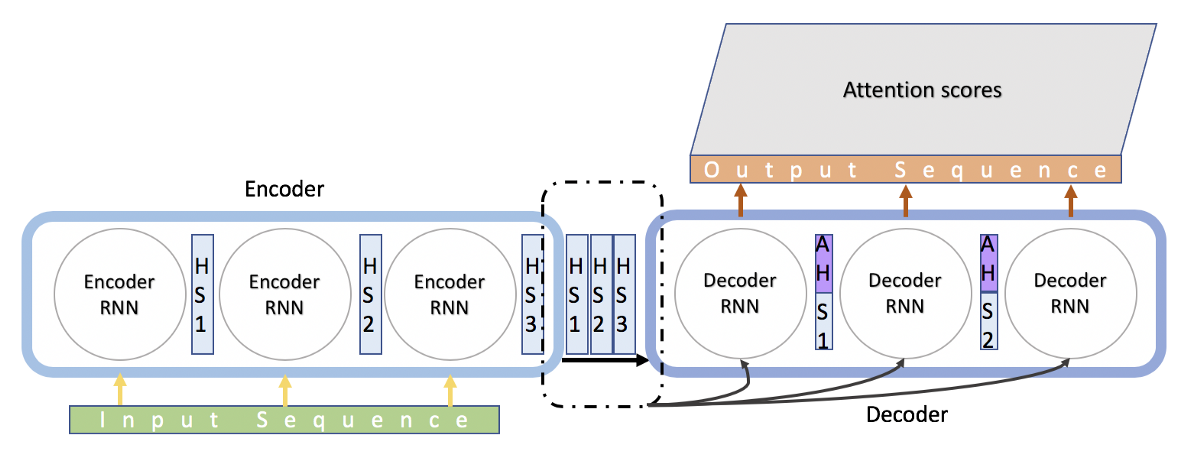

In [121]:
Image(filename='/opt/continuum/data/image/seq2seqAtt.png')

In [122]:
def create_seq2seqAtt():

    input_train = Input(shape=(X_train_sequence.shape[1], X_train_sequence.shape[2]))
    output_train = Input(shape=(y_train_sequence.shape[1], y_train_sequence.shape[2]))    

    encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(48, activation='tanh', 
                                                           dropout=0.2, 
                                                           recurrent_dropout=0.2, 
                                                           return_state=True, 
                                                           return_sequences=True)(input_train)
    
    decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
    
    decoder_stack_h = LSTM(48, activation='tanh', 
                           dropout=0.2, 
                           recurrent_dropout=0.2,
                           return_state=False, 
                           return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])
    
    attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
    attention = Activation('softmax')(attention)
    
    context = dot([attention, encoder_stack_h], axes=[2,1])
    
    decoder_combined_context = concatenate([context, decoder_stack_h])
    
    out = TimeDistributed(Dense(y_train_sequence.shape[2]))(decoder_combined_context)
    model = Model(inputs=input_train, outputs=out)
    
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model

model = create_seq2seqAtt()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24, 19)]     0           []                               
                                                                                                  
 lstm_14 (LSTM)                 [(None, 24, 48),     13056       ['input_3[0][0]']                
                                 (None, 48),                                                      
                                 (None, 48)]                                                      
                                                                                                  
 repeat_vector_2 (RepeatVector)  (None, 24, 48)      0           ['lstm_14[0][1]']                
                                                                                            

<a class="anchor" id="section11.2"></a>
### 11.2 - Seq2SeqAttention Train

In [123]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

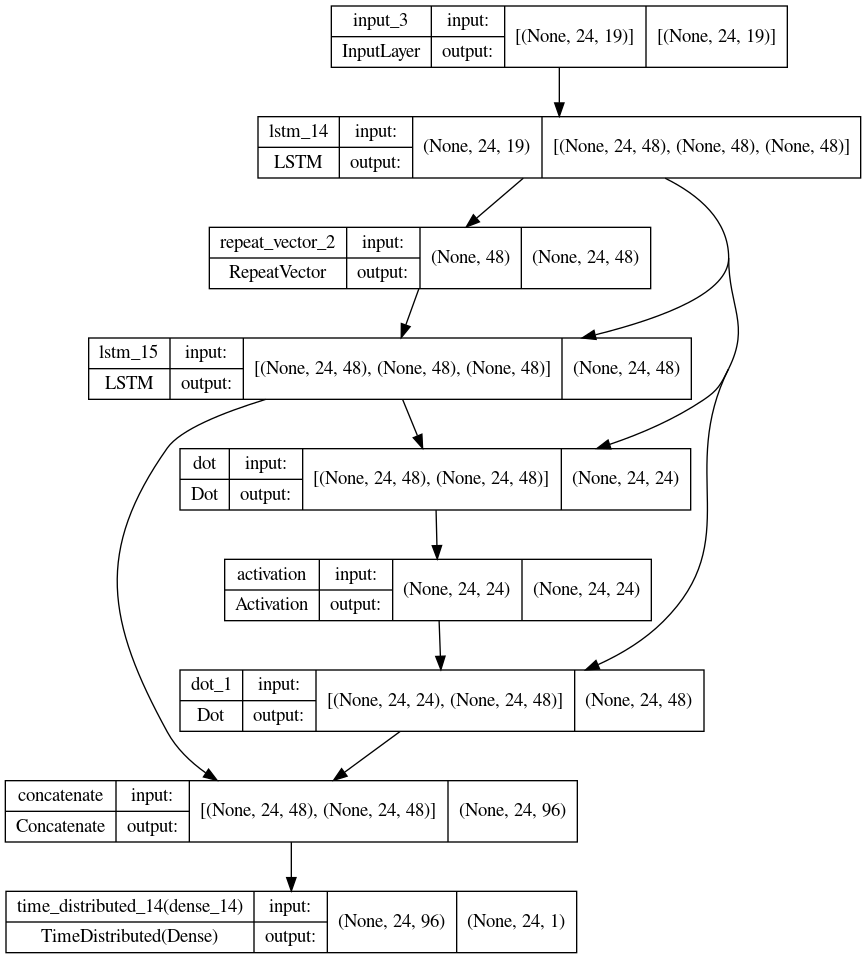

In [124]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 166


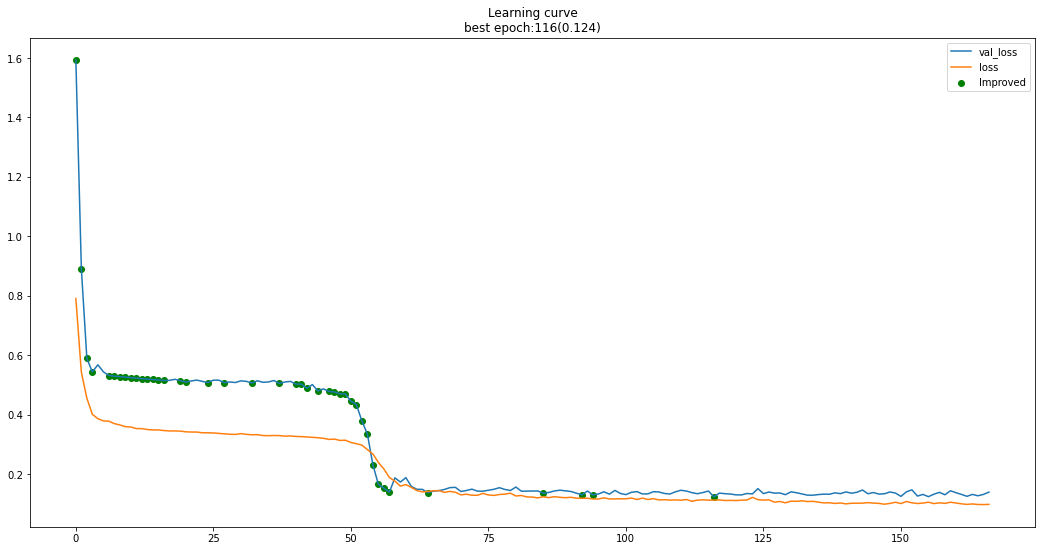

In [125]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section11.3"></a>
### 11.3 - Seq2SeqAttention Validation

In [126]:
pred_scaled = pd.DataFrame(model.predict(X_test_sequence)[0,:].T)
pred_all = pd.DataFrame(np.mean(pred_scaled.T, axis = 1))
#pred_all = pd.DataFrame(pred_scaled)
pred_all.columns = ['Y_PRED']

In [127]:
scorer_s2satt = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Seq2SeqAttention-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_s2satt.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)

scorer_benchmark.add_rdr(scorer_s2satt)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


DTW          RMSE  RdR_SCORE               MODEL_NAME
0  21937.629965   5351.187911   0.592610                   BiLSTM
1  59099.430044  12063.620641   0.000000               RandomWalk
2  30066.735269   8036.460616   0.412539                  Seq2Seq
3  20040.350093   4651.332182   0.637669               CNN-BiLSTM
4  27388.128570   6808.907050   0.486079               TCN-BiLSTM
5  29632.681845   6865.147551   0.464759               MDN-BiLSTM
6  25059.605736   6777.949527   0.507063         Attention-BiLSTM
7  19456.443094   5013.071503   0.627616  Seq2SeqAttention-BiLSTM

In [128]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

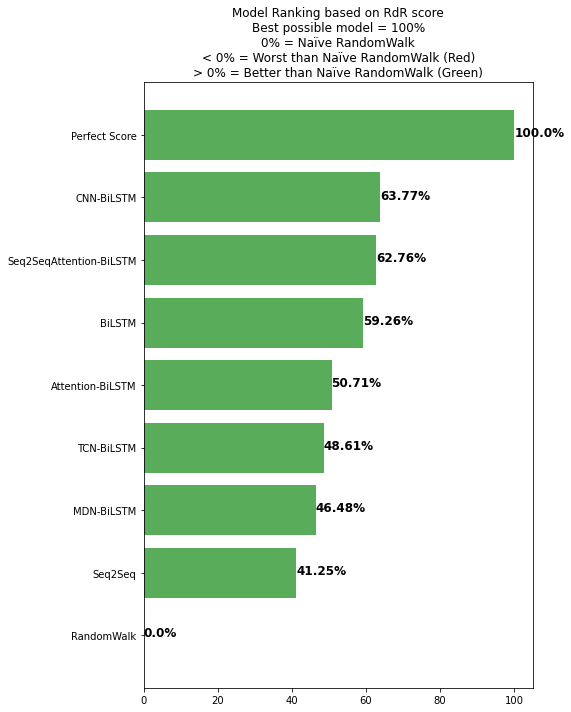

In [129]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section11.4"></a>
### 11.4 - Seq2SeqAttention Forecast

In [130]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=25)

model = create_seq2seq()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch*2, 
                    batch_size = 24,#36, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

pred_fscaled = pd.DataFrame(model.predict(X_forecast)[0,:].T)
pred_forecast = pd.DataFrame(np.mean(pred_fscaled.T, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_forecast.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)

    
X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


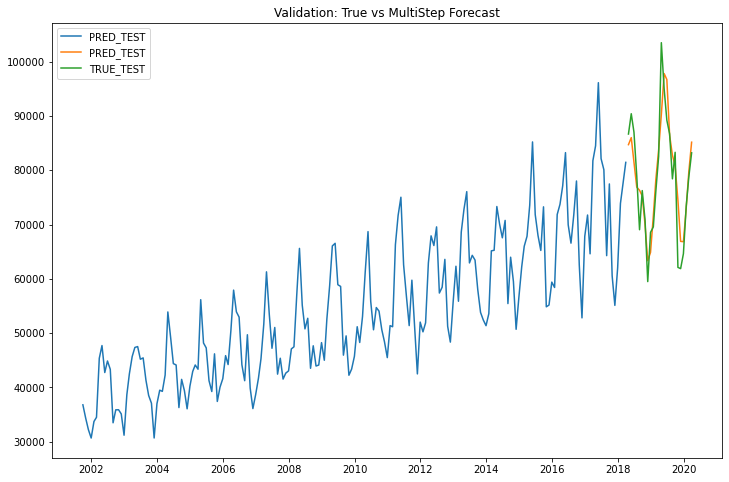

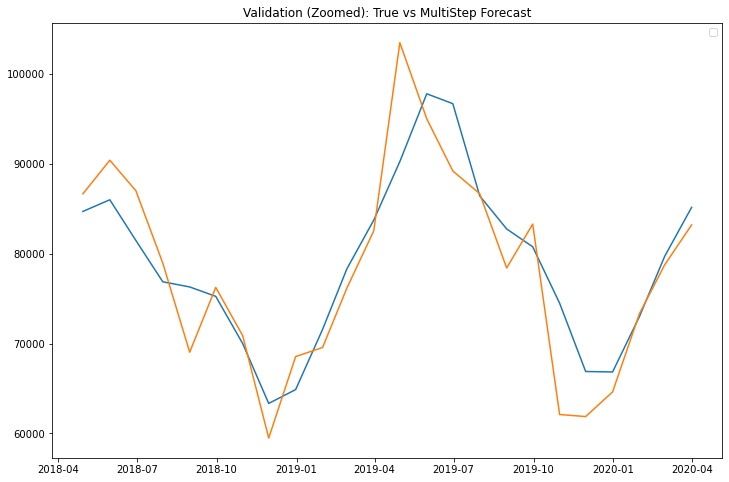

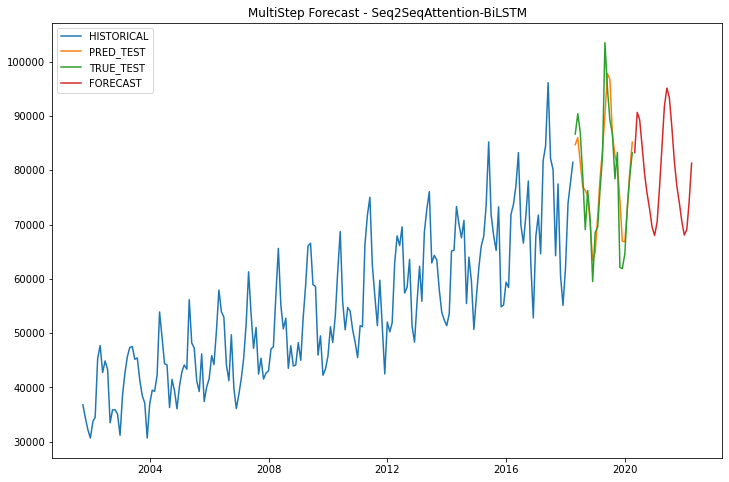

In [131]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

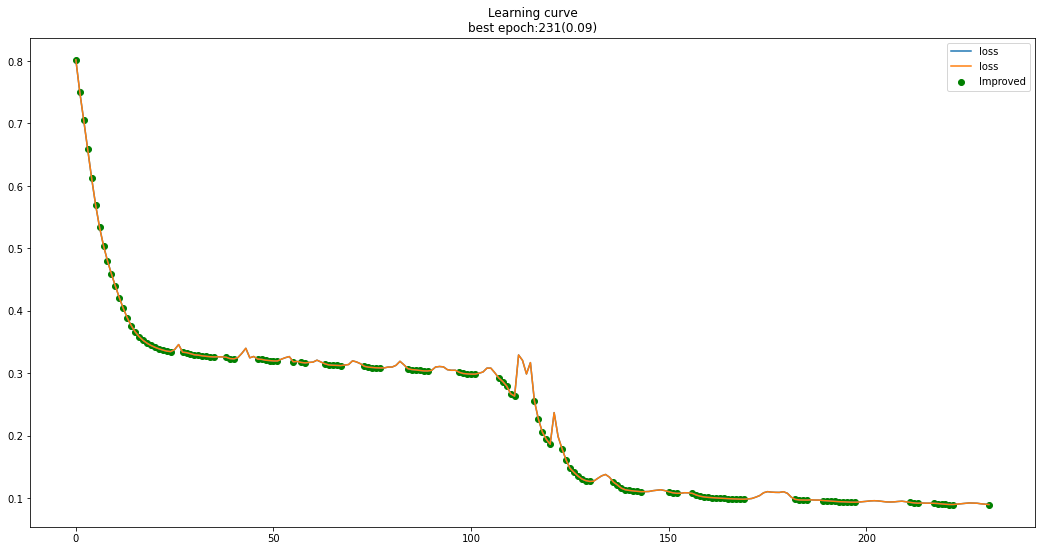

In [132]:
plot_learning_curve(history, 'loss')

<a class="anchor" id="P12"></a>
# Section#12 - MultiHead Attention-BiLSTM

<a class="anchor" id="section12.1"></a>
### 12.1 - MultiHead Attention-BiLSTM Architecture

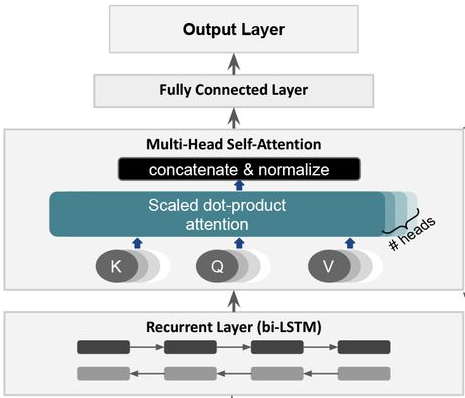

In [133]:
Image(filename='/opt/continuum/data/image/MultiHeadAtt.png')

In [134]:

def create_multihead_BiLSTM():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=input_dim, 
                                 return_sequences=True, 
                                 kernel_initializer = 'uniform',
                                 activation = 'tanh'
                                 )))
    model.add(MultiHeadAttention(head_num = X_train_sequence.shape[2]))
    model.add(Bidirectional(LSTM(input_dim, return_sequences=True, activation = 'tanh')))#,return_sequences=False))
    model.add(TimeDistributed(Dense(units=output_dim, activation = 'linear')))
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)#, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(loss='mse', optimizer=opt)
    return model

model = create_multihead_BiLSTM()

<a class="anchor" id="section12.2"></a>
### 12.2 - MultiHead Attention-BiLSTM Train

In [135]:

monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=16)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 12, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

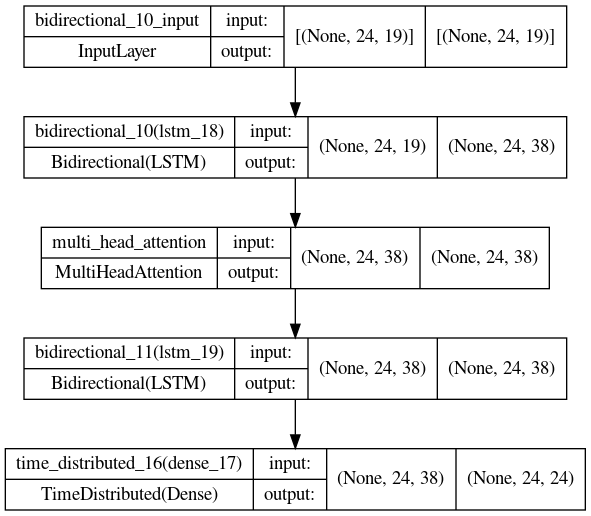

In [136]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 100


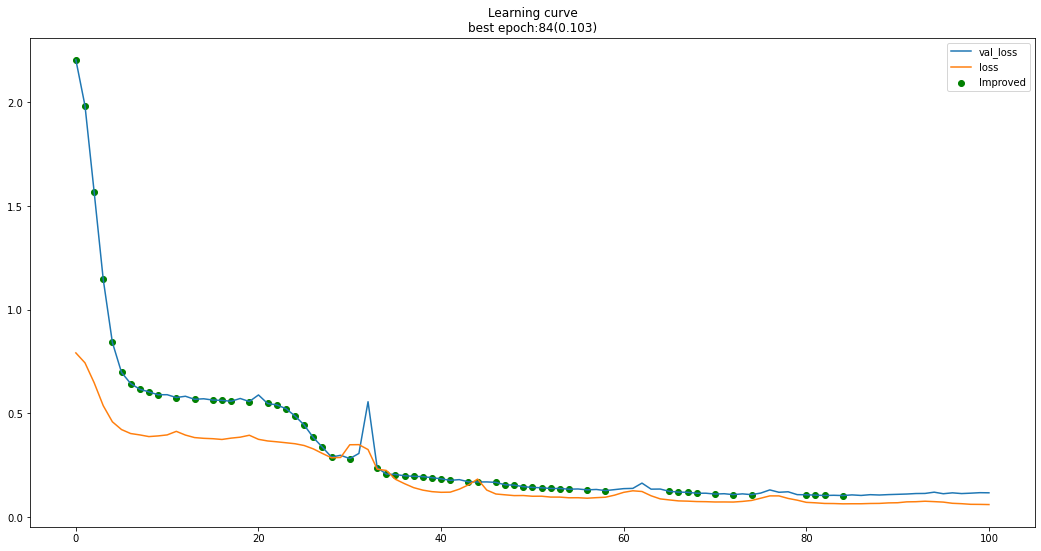

In [137]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section12.3"></a>
### 12.3 - MultiHead Attention-BiLSTM Validation

In [138]:
#pred_scaled = pd.DataFrame(model.predict(X_test_sequence))
#pred_all = pd.DataFrame(pred_scaled.T)

pred_scaled = pd.DataFrame(np.mean(model.predict(X_test_sequence), axis = 0))
pred_all = pd.DataFrame(np.mean(pred_scaled, axis = 1))

pred_all.columns = ['Y_PRED']

In [139]:
scorer_matt = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'MultiHeadAttention-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_matt.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_matt.score())
scorer_benchmark.add_rdr(scorer_matt)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.5258886246752839


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0  21937.629965   5351.187911   0.592610                     BiLSTM
1  59099.430044  12063.620641   0.000000                 RandomWalk
2  30066.735269   8036.460616   0.412539                    Seq2Seq
3  20040.350093   4651.332182   0.637669                 CNN-BiLSTM
4  27388.128570   6808.907050   0.486079                 TCN-BiLSTM
5  29632.681845   6865.147551   0.464759                 MDN-BiLSTM
6  25059.605736   6777.949527   0.507063           Attention-BiLSTM
7  19456.443094   5013.071503   0.627616    Seq2SeqAttention-BiLSTM
8  24052.609357   6529.281222   0.525889  MultiHeadAttention-BiLSTM

In [140]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

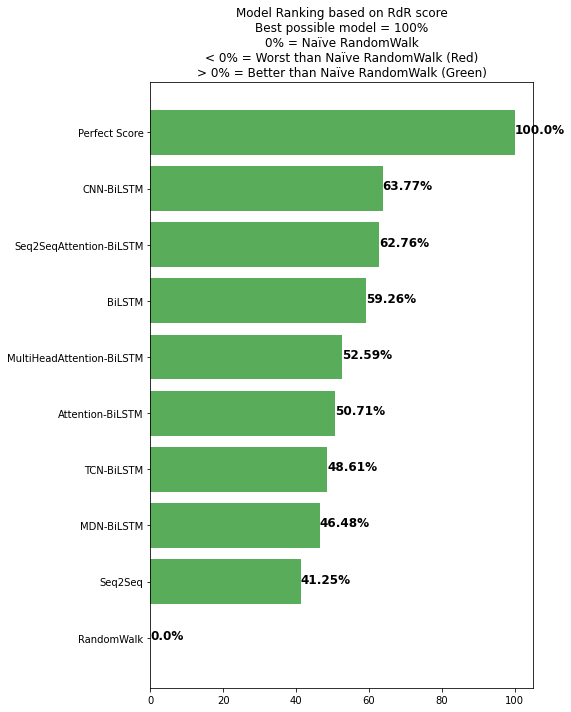

In [141]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section12.4"></a>
### 12.4 - MultiHead Attention-BiLSTM Forecast

In [142]:

monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=20)

model = create_multihead_BiLSTM()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 12, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast

X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


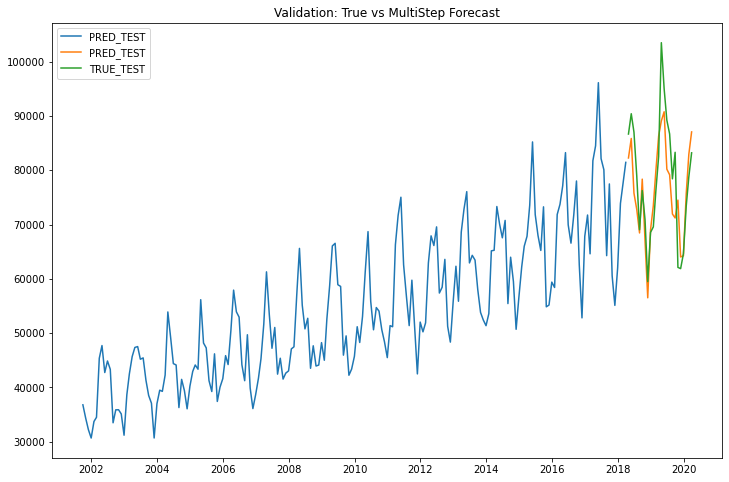

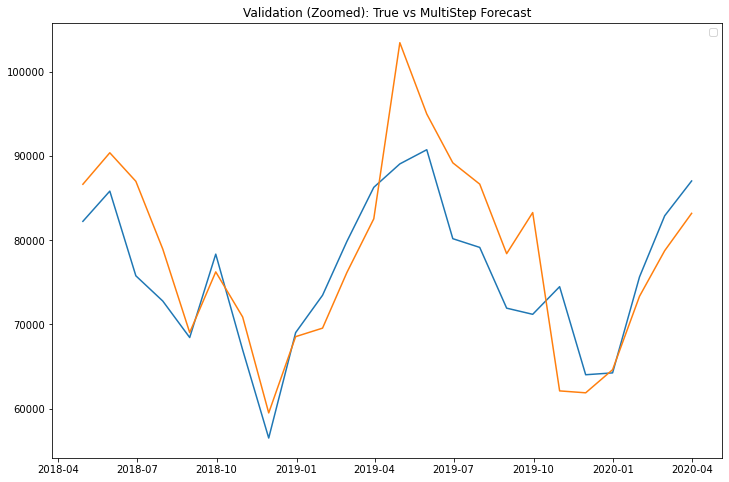

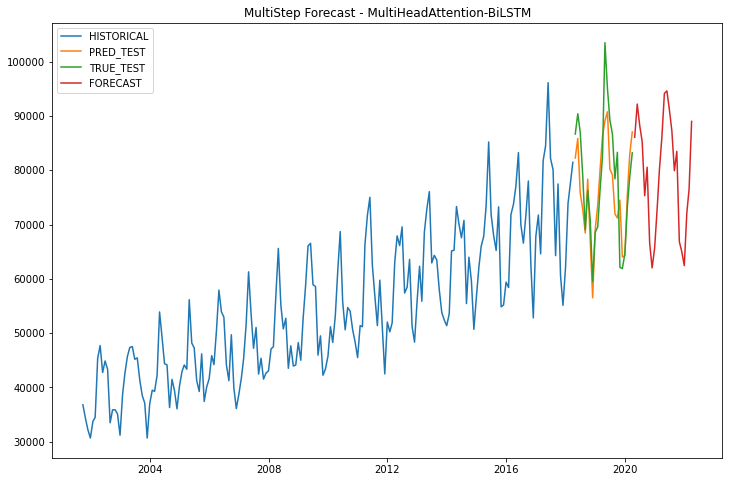

In [143]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

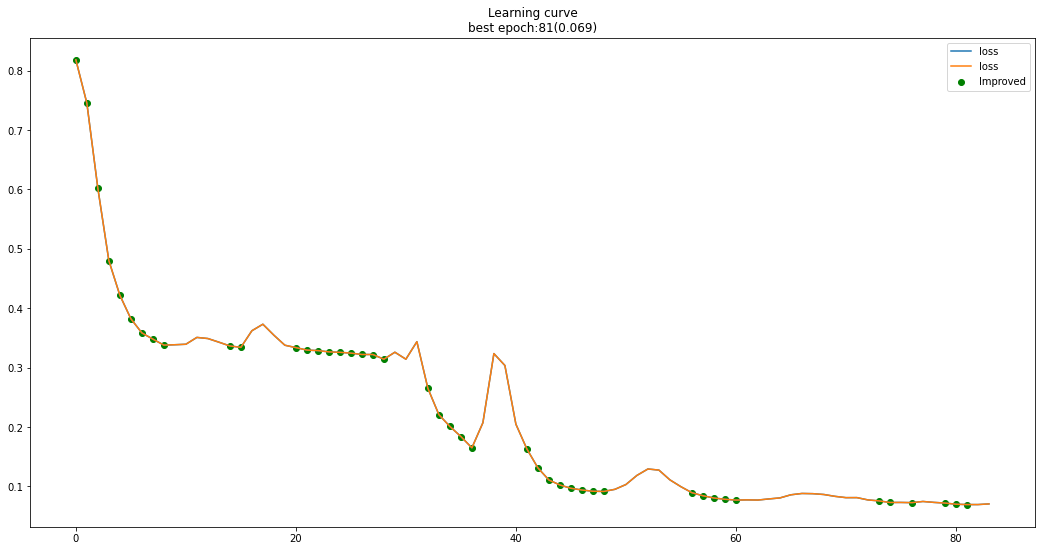

In [144]:
plot_learning_curve(history, 'loss')

<a class="anchor" id="P13"></a>
# Section#13 - Time2Vec-BiLSTM

<a class="anchor" id="section13.1"></a>
### 13.1 - Time2Vec-BiLSTM Architecture

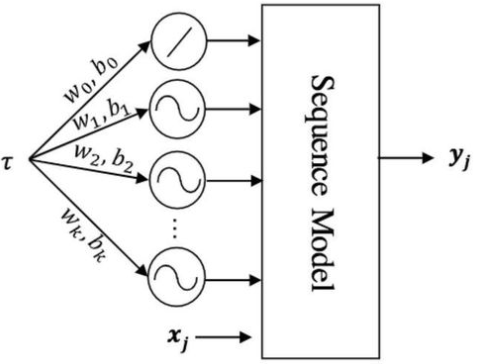

In [145]:
Image(filename='/opt/continuum/data/image/t2v.png')

In [146]:
class Time2Vec(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(Time2Vec, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [147]:
def create_t2v_bilstm():
    inp = Input(shape=(X_train_sequence.shape[1],
                   X_train_sequence.shape[2]))
    x = Time2Vec(120)(inp)
    x = Bidirectional(LSTM(48, activation='tanh', return_sequences = True))(x)
    x = Dense(y_train_sequence.shape[1])(x)

    model = Model(inp, x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    model.summary()
    
    return model
    
model = create_t2v_bilstm()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 time2_vec (Time2Vec)        (None, 24, 139)           5208      
                                                                 
 bidirectional_14 (Bidirecti  (None, 24, 96)           72192     
 onal)                                                           
                                                                 
 dense_19 (Dense)            (None, 24, 24)            2328      
                                                                 
Total params: 79,728
Trainable params: 79,728
Non-trainable params: 0
_________________________________________________________________


<a class="anchor" id="section13.2"></a>
### 13.2 - Time2Vec-BiLSTM Train

In [148]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

..

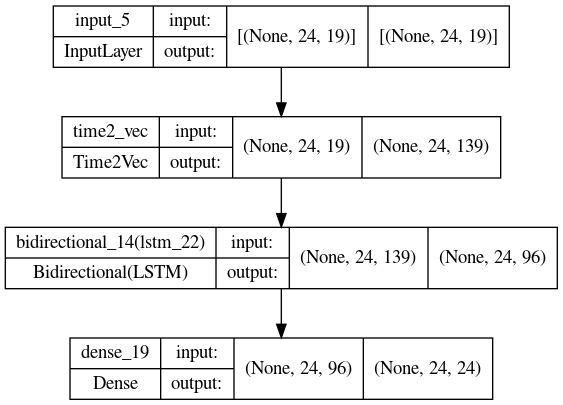

In [149]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 104


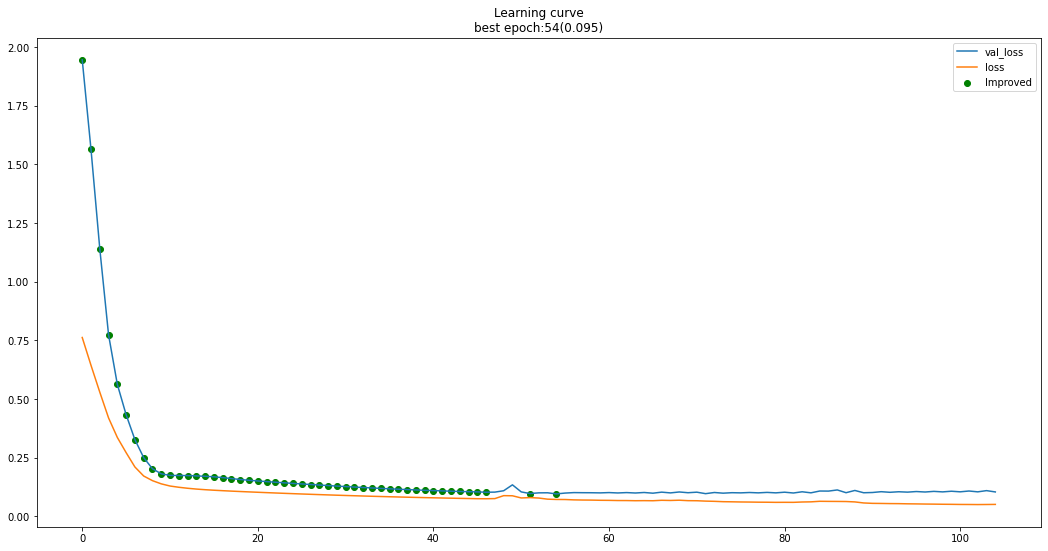

In [150]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section13.3"></a>
### 13.3 - Time2Vec-BiLSTM Validation

In [151]:
pred_all = pd.DataFrame(model.predict(X_forecast)[0,:].T)
pred_all = pd.DataFrame(np.mean(pred_all.T, axis = 1))
pred_all.columns = ['Y_PRED']

In [152]:
scorer_t2vbilstm = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Time2Vec-BiLSTM')

average_ensemble_model.append(y_pred)

scorer_t2vbilstm.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_t2vbilstm.score())
scorer_benchmark.add_rdr(scorer_t2vbilstm)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.6601035891151608


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0  21937.629965   5351.187911   0.592610                     BiLSTM
1  59099.430044  12063.620641   0.000000                 RandomWalk
2  30066.735269   8036.460616   0.412539                    Seq2Seq
3  20040.350093   4651.332182   0.637669                 CNN-BiLSTM
4  27388.128570   6808.907050   0.486079                 TCN-BiLSTM
5  29632.681845   6865.147551   0.464759                 MDN-BiLSTM
6  25059.605736   6777.949527   0.507063           Attention-BiLSTM
7  19456.443094   5013.071503   0.627616    Seq2SeqAttention-BiLSTM
8  24052.609357   6529.281222   0.525889  MultiHeadAttention-BiLSTM
9  19955.989136   4127.263492   0.660104            Time2Vec-BiLSTM

In [153]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

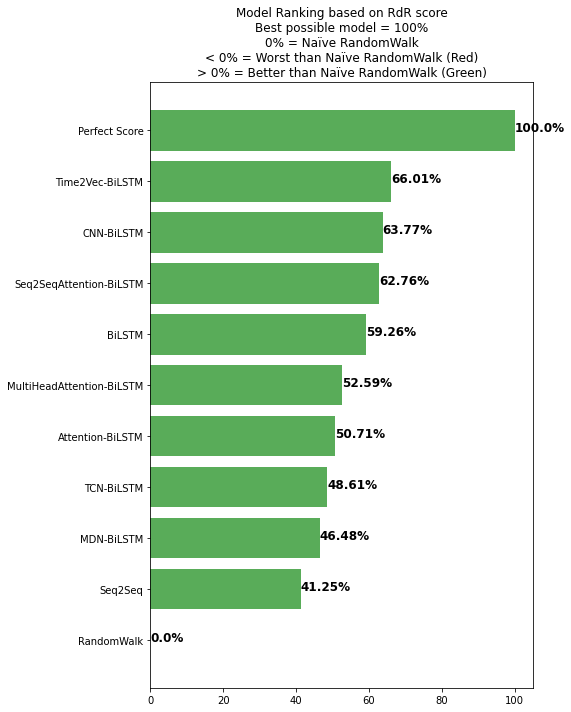

In [154]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section13.4"></a>
### 13.4 - Time2Vec-BiLSTM Forecast

In [155]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)

model = create_t2v_bilstm()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 24, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast



X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 24, 19)]          0         
                                                                 
 time2_vec_1 (Time2Vec)      (None, 24, 139)           5208      
                                                                 
 bidirectional_15 (Bidirecti  (None, 24, 96)           72192     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 24, 24)            2328      
                                                                 
Total params: 79,728
Trainable params: 79,728
Non-trainable params: 0
_________________________________________________________________
.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


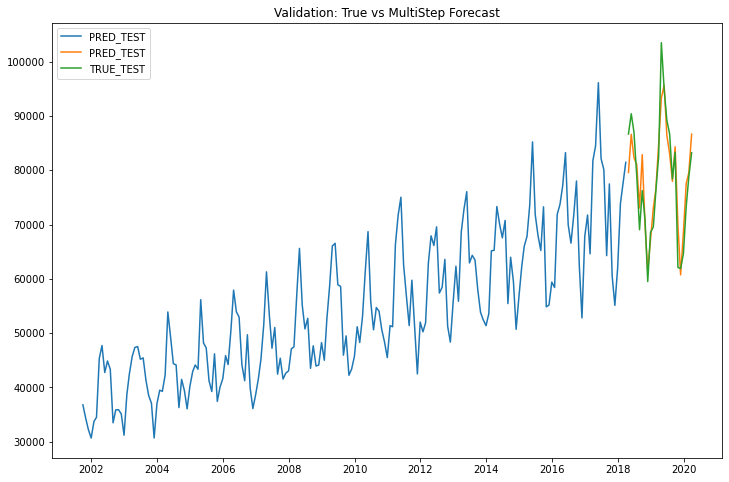

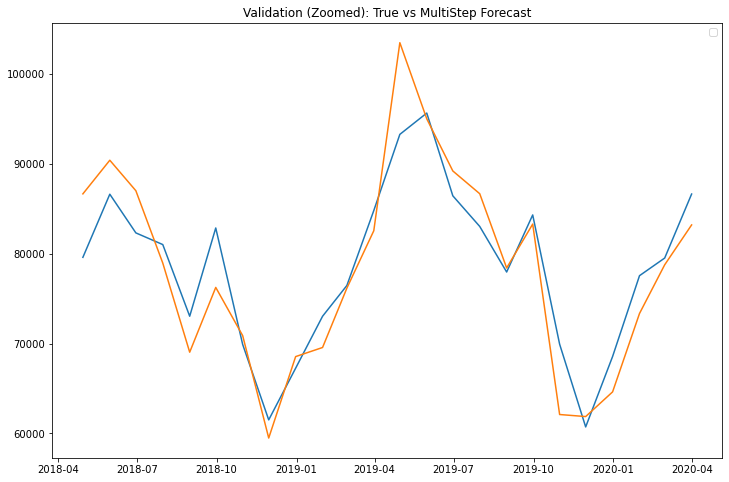

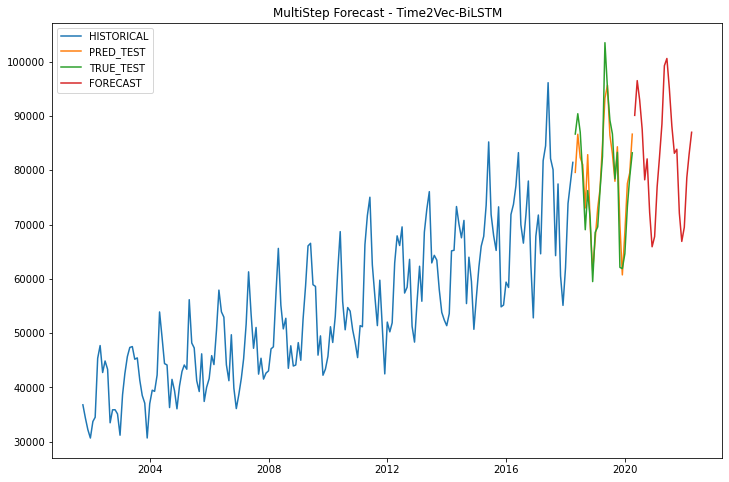

In [156]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

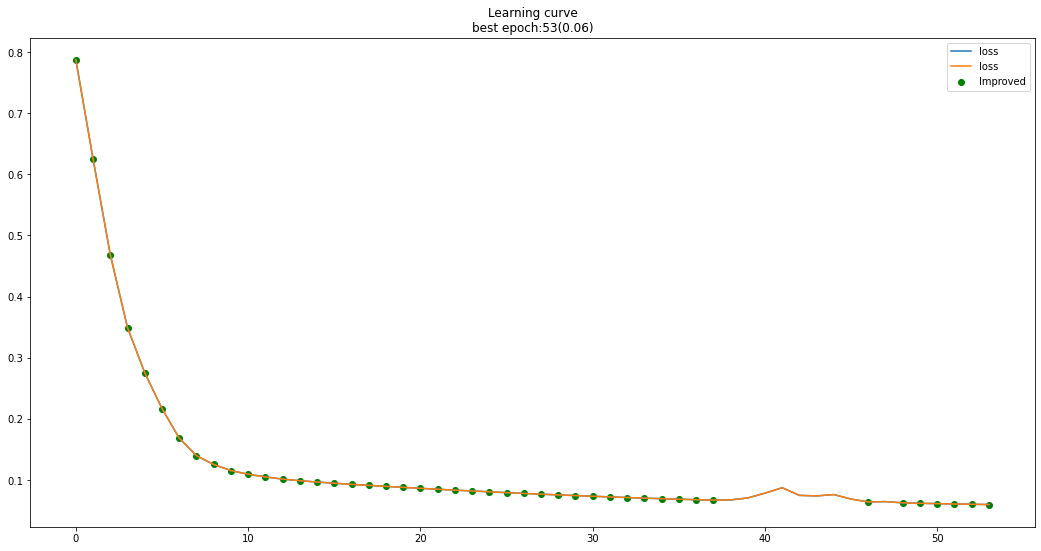

In [157]:
plot_learning_curve(history, 'loss')

<a class="anchor" id="P14"></a>
# Section#14 - Time2Vec-Transformer

<a class="anchor" id="section14.1"></a>
### 14.1 - Time2Vec-Transformer Architecture

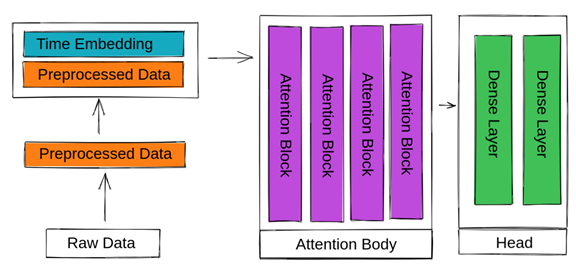

In [158]:
Image(filename='/opt/continuum/data/image/t2v-tf.png')

<a class="anchor" id="section14.2"></a>
### 14.2 - Time2Vec-Transformer Train

In [159]:
class Time2Vec4TF(tf.keras.layers.Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vec4TF, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2

In [160]:

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class T2VTransformer(keras.Model):
    def __init__(
            self,
            num_hid=64, # embed_dim - num of features
            time_steps=7,
            num_head = 2,
            num_feed_forward=128, # pointwise dim
            num_layers_enc = 4,
            time_embedding = False,
    ):
        super().__init__()
        self.num_hid = num_hid
        if time_embedding:
            self.num_hid += 2
            self.tv = Time2Vec4TF(time_steps)
        else:
            self.tv = None
        self.numlayers_enc = num_layers_enc
        self.enc_input = layers.Input((time_steps, self.num_hid))
        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(self.num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )
        self.GlobalAveragePooling1D = layers.GlobalAveragePooling1D(data_format='channels_last')
        self.out = layers.Dense(units=time_steps, activation='linear')        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        
    def call(self, inputs):
        if self.tv:
            x = self.tv(inputs)
            x = self.concat([inputs, x])
            x = self.encoder(x)
        else:
            x = self.encoder(inputs)
        x = self.GlobalAveragePooling1D(x)
        y = self.out(x)
        return y

In [161]:
def create_t2v_transformer():
    num_heads=2
    num_layers_enc=2
    num_feed_forward=64
    num_features = X_train_sequence.shape[2]
    time_steps = y_train_sequence.shape[1]
    epochs = 100
    batch_size = 128

    model = T2VTransformer(num_hid=num_features,
                           time_steps=time_steps,
                           time_embedding=True,
                           num_head=y_train_sequence.shape[1],
                           num_layers_enc=num_layers_enc,
                           num_feed_forward=num_feed_forward)
    opt = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999, amsgrad=True)
    model.compile(optimizer=opt, loss='mse')
    
    return model
    
model = create_t2v_transformer()

In [162]:
monitor_label = 'val_loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)
history = model.fit(X_train_sequence, 
                    y_train_sequence,
                    epochs=1000, 
                    batch_size = 24, 
                    validation_data = (X_train_full[-24:, :, :],
                                       y_train_full[-24:, :, :]),
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

....

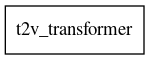

In [163]:
plot_model(model, show_shapes=True, show_layer_names=True)

max epoch : 343


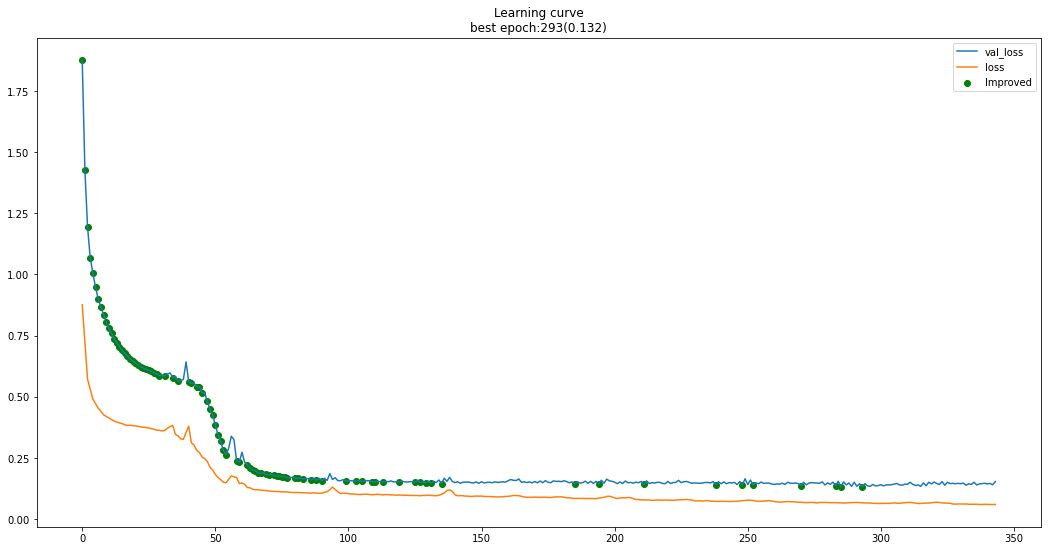

In [164]:
plot_learning_curve(history)
max_epoch = np.max(history.epoch)
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
best_epoch = hist[hist[monitor_label] == np.min(hist[monitor_label])]['epoch'].values[0]
print('max epoch :', max_epoch)

<a class="anchor" id="section14.3"></a>
### 14.3 - Time2Vec-Transformer Validation

In [165]:
pred_all = pd.DataFrame(model.predict(X_forecast)).T
pred_all.columns = ['Y_PRED']

In [166]:
scorer_t2vtf = RdR_scorer()

ts_orig, y_colname, n_steps, y_true, y_pred, model_name, freq = get_feat_for_scoring(ts = ts_sequence.copy(), 
                                                                                     y_scaler = y_scaler_sequence, 
                                                                                     dict_ts = dict_ts_sequence.copy(), 
                                                                                     pred_df = pred_all.copy(), 
                                                                                     model_name = 'Time2Vec-Transformer')

average_ensemble_model.append(y_pred)

scorer_t2vtf.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), y_pred.copy(), model_name = model_name, freq = freq)
print(scorer_t2vtf.score())
scorer_benchmark.add_rdr(scorer_t2vtf)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.6019307145947994


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0   21937.629965   5351.187911   0.592610                     BiLSTM
1   59099.430044  12063.620641   0.000000                 RandomWalk
2   30066.735269   8036.460616   0.412539                    Seq2Seq
3   20040.350093   4651.332182   0.637669                 CNN-BiLSTM
4   27388.128570   6808.907050   0.486079                 TCN-BiLSTM
5   29632.681845   6865.147551   0.464759                 MDN-BiLSTM
6   25059.605736   6777.949527   0.507063           Attention-BiLSTM
7   19456.443094   5013.071503   0.627616    Seq2SeqAttention-BiLSTM
8   24052.609357   6529.281222   0.525889  MultiHeadAttention-BiLSTM
9   19955.989136   4127.263492   0.660104            Time2Vec-BiLSTM
10  17242.363150   6084.731057   0.601931       Time2Vec-Transformer

In [167]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

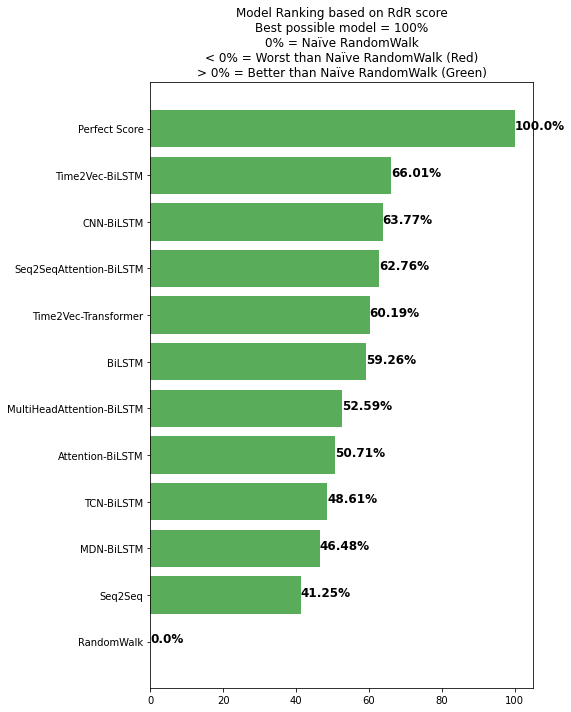

In [168]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section14.4"></a>
### 14.4 - Time2Vec-Transformer Forecast

In [169]:
monitor_label = 'loss'
early_stop = EarlyStopping(monitor=monitor_label, patience=50)

model = create_t2v_transformer()

history = model.fit(X_train_full, 
                    y_train_full,
                    epochs=best_epoch, 
                    batch_size = 24, 
                    #validation_split = 0.2, 
                    shuffle = False,
                    verbose=0,
                    callbacks=[early_stop,  PrintDot()])

#pred_fscaled = pd.DataFrame(model.predict(X_forecast))
#pred_forecast = pd.DataFrame(pred_fscaled.T)

pred_fscaled = pd.DataFrame(np.mean(model.predict(X_forecast), axis = 0))
pred_fscaled = pd.DataFrame(np.mean(pred_fscaled, axis = 1))

pred_forecast = inverse_forecast(y_scaler_forecast, dict_ts_sequence.copy(), pred_fscaled.copy())

pred_forecast.columns = ['Y_PRED']
for col in pred_forecast.columns:
    pred_forecast[col] =pred_forecast[col].astype(float)
pred_forecast



X_pred_date = get_pred_dates(dict_ts_sequence['freq'], ts_sequence, dict_ts_sequence['date_colname'], dict_ts_sequence['n_leads'])
pred_forecast.index = X_pred_date.index

average_ensemble_model_forecast.append(pred_forecast)

...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


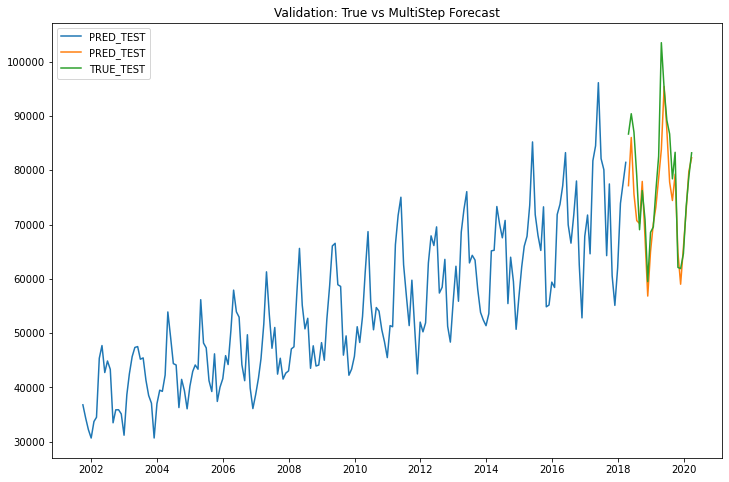

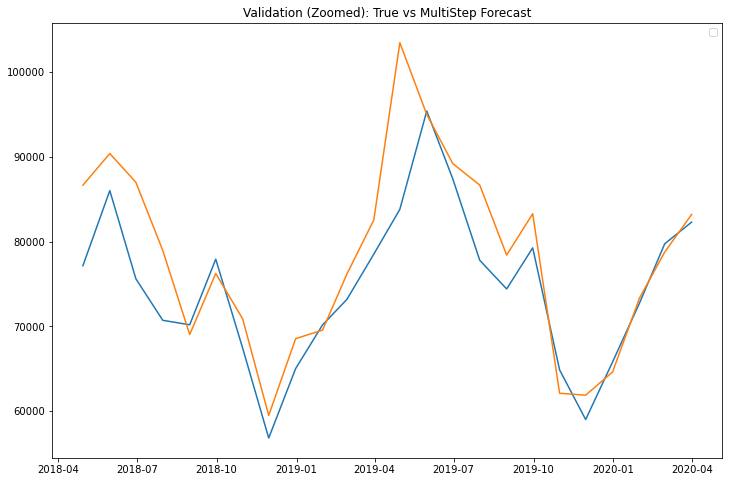

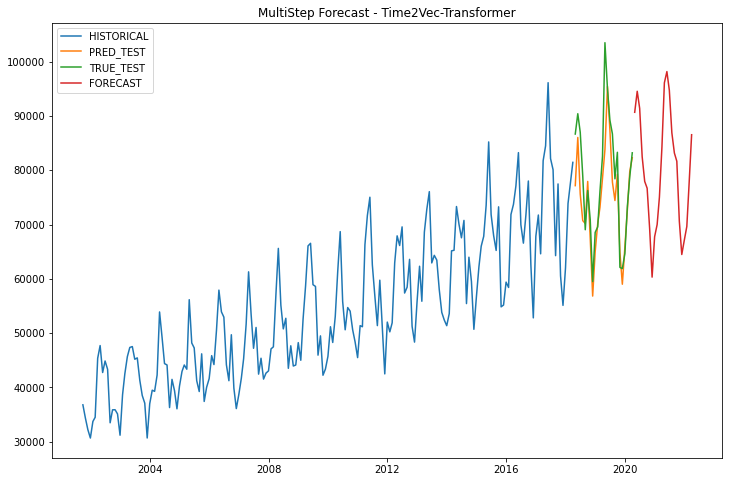

In [170]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             inverse_forecast(y_scaler_sequence, dict_ts_sequence, pred_all), 
             y_scaler_sequence, 
             pred_forecast, 
             y_scaler_forecast, 
             dict_ts_sequence)

<a class="anchor" id="P15"></a>
# Section#15 - Average Ensemble Model

<a class="anchor" id="section15.1"></a>
### 15.1 - Average Ensemble Model Validation

In [171]:
average_ensemble_model_df = pd.DataFrame(np.mean(pd.concat(average_ensemble_model, axis = 1), axis = 1))
average_ensemble_model_df.columns = ['Y_PRED']
average_ensemble_model_df.index = y_pred.index

In [172]:
scorer_avg = RdR_scorer()

scorer_avg.fit(ts_orig.copy(), y_colname, n_steps, y_true.copy(), average_ensemble_model_df.copy(), model_name = 'AverageEnsemble', freq = freq)
print(scorer_avg.score())
scorer_benchmark.add_rdr(scorer_avg)

2020-04-30 00:00:00 2022-03-31 00:00:00
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02427D+01    |proj g|=  6.31495D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.315D-07   1.024D+01
  F =   10.242658942547690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


0.6164053859818389


DTW          RMSE  RdR_SCORE                 MODEL_NAME
0   21937.629965   5351.187911   0.592610                     BiLSTM
1   59099.430044  12063.620641   0.000000                 RandomWalk
2   30066.735269   8036.460616   0.412539                    Seq2Seq
3   20040.350093   4651.332182   0.637669                 CNN-BiLSTM
4   27388.128570   6808.907050   0.486079                 TCN-BiLSTM
5   29632.681845   6865.147551   0.464759                 MDN-BiLSTM
6   25059.605736   6777.949527   0.507063           Attention-BiLSTM
7   19456.443094   5013.071503   0.627616    Seq2SeqAttention-BiLSTM
8   24052.609357   6529.281222   0.525889  MultiHeadAttention-BiLSTM
9   19955.989136   4127.263492   0.660104            Time2Vec-BiLSTM
10  17242.363150   6084.731057   0.601931       Time2Vec-Transformer
11  21142.255765   4939.434921   0.616405            AverageEnsemble

In [173]:
scorer_benchmark.get_rdr_interpretation()

'GOOD PERFORMANCE: With a stable trend and no major unpredictable changes, the model is 59.26% better than a naïve random decision. The mean forecast accuracy is 93.02% (around 91.01% and 94.83% of accuracy per forecasted datapoint)'

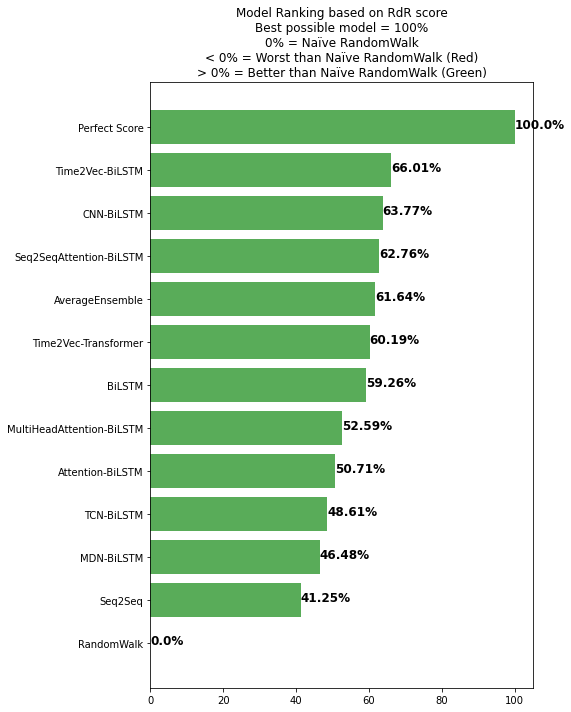

In [174]:
scorer_benchmark.plot_rdr_rank()

<a class="anchor" id="section15.2"></a>
### 15.2 - Average Ensemble Model Forecast

In [175]:
average_ensemble_model_forecast_df = pd.DataFrame(np.mean(pd.concat(average_ensemble_model_forecast, axis = 1), axis = 1))
average_ensemble_model_forecast_df.columns = ['Y_PRED']
average_ensemble_model_forecast_df.index = pred_forecast.index

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


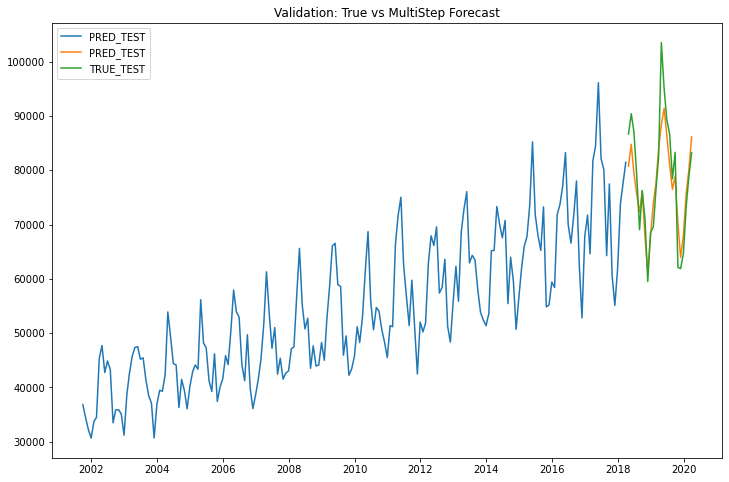

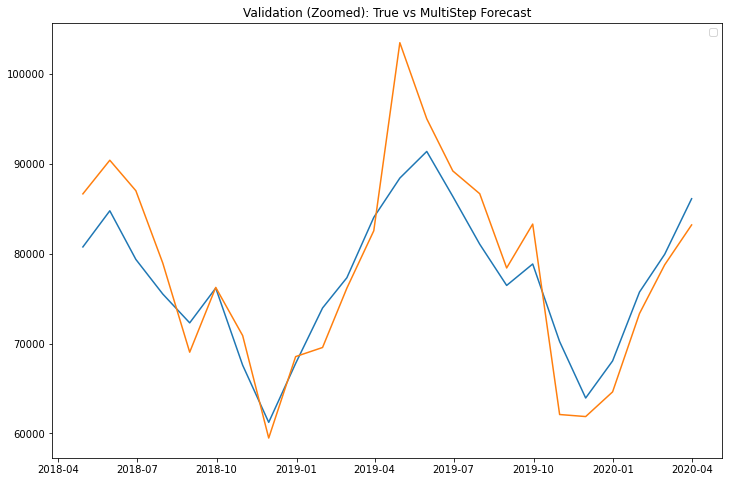

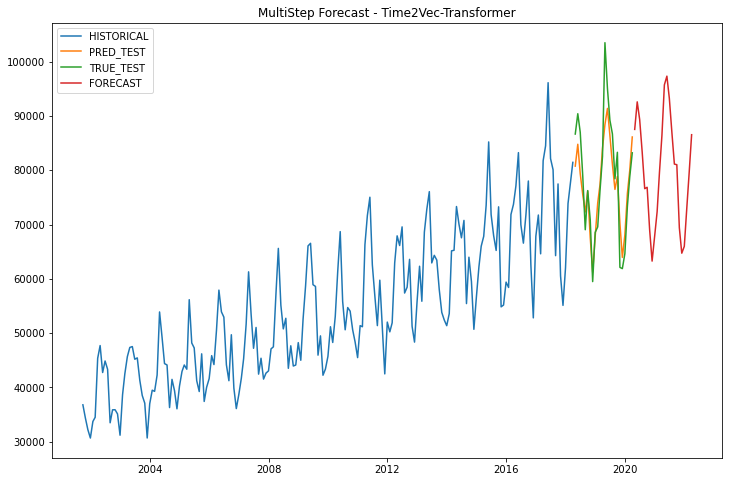

In [176]:
plot_results(ts_sequence_train, 
             ts_sequence, 
             average_ensemble_model_df.copy(), 
             y_scaler_sequence, 
             average_ensemble_model_forecast_df.copy(), 
             y_scaler_forecast, 
             dict_ts_sequence)


<a class="anchor" id="P16"></a>
# Section#16 - Final Benchmark

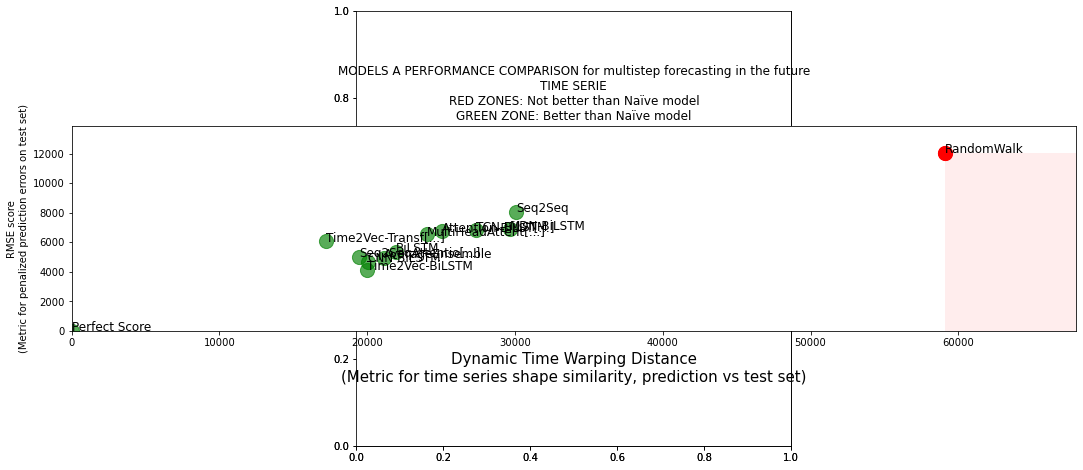

In [177]:
scorer_benchmark.plot_rdr(figsize=(18,8),
                          scatter_size = 200,
                         scatter_label_size = 12)


In [178]:
scores_df = scorer_benchmark.get_df_viz()

In [179]:
scores_df.to_csv('scores/scores_easy_' + str(seed_value) +'.csv', sep = ';', index = False)

OSError: Cannot save file into a non-existent directory: 'scores'

In [ ]:

files_list = []
for fname in os.listdir('scores/'):    # change directory as needed
    #print(fname)
    if os.path.isfile(fname):    # make sure it's a file, not a directory entry
        if fname.find('scores_easy_') > -1:    # search for string
            files_list.append(fname)


In [ ]:
files_list

In [ ]:
li = []
for filename in files_list:
    df = pd.read_csv(filename, sep = ';')
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame

In [ ]:

fig, ax = plt.subplots(figsize = (18, 8))
for model_name in np.unique(frame['MODEL_NAME']):
    print(model_name)
    sns.kdeplot(frame[frame['MODEL_NAME'] == model_name]['RdR_SCORE'], label = model_name)
    plt.legend()

In [ ]:
frame.groupby(['MODEL_NAME']).mean().reset_index().sort_values(by = 'RdR_SCORE', ascending = False)

In [ ]:
frame.groupby(['MODEL_NAME']).std().reset_index().sort_values(by = 'RdR_SCORE', ascending = True)

In [ ]:
frame.groupby(['MODEL_NAME']).min().reset_index().sort_values(by = 'RdR_SCORE', ascending = False)

In [ ]:
frame.groupby(['MODEL_NAME']).max().reset_index().sort_values(by = 'RdR_SCORE', ascending = False)